# Analysis of hover points

In [1]:
%matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd

from tools.data_loader import moving_average

import glob
import os

In [2]:
# global plotting settings
markersize= 15
cmap = cm.cool

In [3]:
# declare ALL list objects necessary

v_induced = 14.345219306215128

In [4]:
# get the .csv files for the given velocity limit
def get_files_for_limit(limit, flight, discard=True):
    
    v_limit = limit * 0.01 * v_induced
    data_directory = flight + f'hover_{limit}_limit'
    csv_files = glob.glob(os.path.join(data_directory, "*.csv"))
    #print(csv_files)
    sorted_files = []
    #return csv_files
    # sort sequences in ascending order
    for i in range(len(csv_files)):
        for e in csv_files:
            if f'sequence_{i}_' in e:
                #print(e)
                sorted_files.append(e)
                break
    
    # discard first and land sequence (vehicle on ground before takeoff and after landing)
    if discard:
        return sorted_files[1:-1]
    
    else:
        return sorted_files
    

In [5]:
flight = f'../flight_data/2022-08-01_ag_field/flight_6_first_hover_flight/'
#flight = f'../flight_data/2022-08-01_ag_field/flight_8_second_hover_flight/'
#flight = f'../flight_data/2022-07-20_ag_field/flight_0/'

csv_files = get_files_for_limit(1.0, flight, discard=False)
csv_files_full = get_files_for_limit(5, flight, discard=False)

sequence = []
full_flight = pd.DataFrame()

# stack sequences
for file in csv_files:
    sequence.append(pd.read_csv(file))    

for file_full in csv_files_full:
    full_flight = pd.concat([full_flight, pd.read_csv(file_full)])

In [6]:
useCalibration = True

if useCalibration:
    motorCurrentBias = np.array([6.36, 2.10, -2.27, 0.09, 6.22, 3.01, -2.66, -1.55])
    motorVoltageBias = np.array([0.07, 0.25, 0.24, 0.24, 0.17, 0.46, -0.04, 0.14]) # bias from ground test
    additionalBias = np.array([0, 0, 0.04, 0, 0, 0, 0, -0.04]) # bias through aggregated flight data
    #motorVoltageBias = np.array([0.056, 0.331, 0.223, 0.214, 0.146, 0.461, -0.0568, 0.1155])
    #motorVoltageBias = np.array([0.06, 0.33, 0.22, 0.21, 0.15, 0.46, -0.06, 0.12])


else:
    motorCurrentBias = np.zeros(8)
    motorVoltageBias = np.zeros(8)

In [7]:
#flight_data = sequence[4]
flight_data = full_flight
#flight_data.rename(columns = {' omega1':'omega1'}, inplace = True)

time = ((flight_data['t'].values - min(flight_data['t'].values)) / 10e5)
#time = flight_data['t'].values / 10e5 # - min(flight_data['t'].values)) / 10e5)

# get position and velocities
x = flight_data['x'].values
y = flight_data['y'].values
z = flight_data['z'].values

u = flight_data['u'].values
v = flight_data['v'].values
w = flight_data['w'].values

p = flight_data['p'].values
q = flight_data['q'].values
r = flight_data['r'].values

#delta0 = flight_data['nsh[0]'].values

# get RPM, voltage and current
omega = [flight_data[f'omega{i}'] for i in range(1,9)]
voltage = [(flight_data[f'U1{i}'] - motorVoltageBias[i-1] - additionalBias[i-1]) for i in range(1,9)]
current = [(flight_data[f'I1{i}'] - motorCurrentBias[i-1]) for i in range(1,9)]
control = [flight_data[f'ctrl_{i}'] for i in range(1,9)]
power = [voltage[i] * current[i] for i in range(0,8)]
power_pair = {'16': power[0]+power[5], '25': power[1]+power[4], '38': power[2]+power[7], '47': power[3]+power[6]}
total_power = sum(power)
avg_omega = sum(omega)/8

v_norm = np.sqrt(u ** 2 + v ** 2 + w ** 2)

In [8]:
print(np.mean(voltage[1]-np.mean(voltage[4])))
print(np.mean(voltage[0]-np.mean(voltage[5])))
print(np.mean(voltage[2]-np.mean(voltage[7])))
print(np.mean(voltage[3]-np.mean(voltage[6])))

-0.0021024600563974895
-0.018894242962656793
0.012921633273693386
0.007851889424409113


<IPython.core.display.Javascript object>


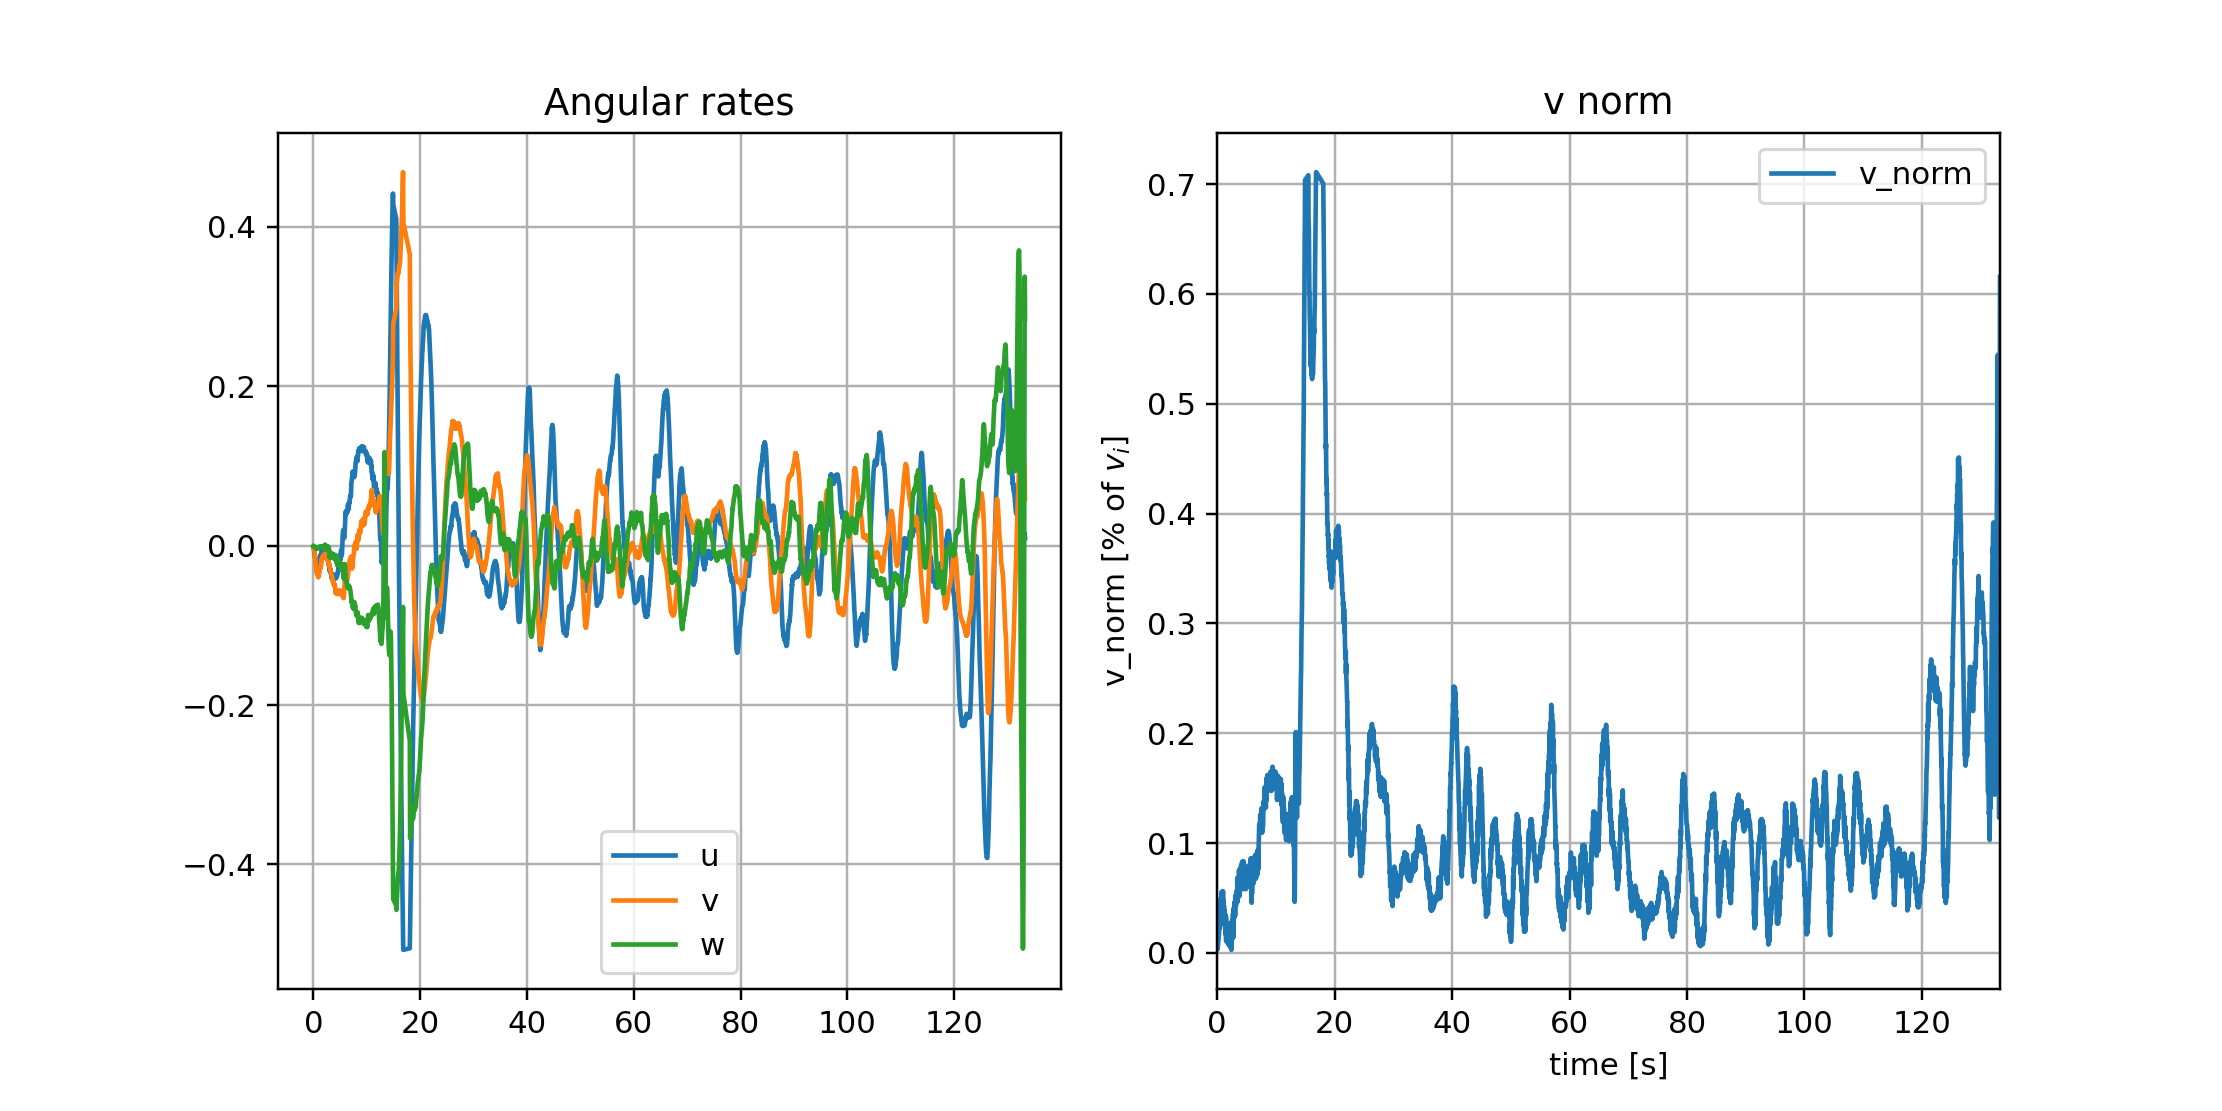

(0.0, 133.287387)

In [9]:
# plot histogram of vnorm with corresponding limit

fig0, ax0 = plt.subplots(1, 2, figsize=(10,5))

v_norm_percentage = (v_norm/v_induced)*100  # vnorm in percentage of v_i

# First flight
#ax0[0].hist(v_norm_percentage, bins=20)

ax0[0].plot(time, moving_average(u), label='u')
ax0[0].plot(time, moving_average(v), label='v')
ax0[0].plot(time, moving_average(w), label='w')

#ax0[0].plot(time, moving_average(p)*180/np.pi, label='p: roll rate [$^{\circ}/s$]')
#ax0[0].plot(time, moving_average(q)*180/np.pi, label='q: pitch rate [$^{\circ}/s$]')
#ax0[0].plot(time, moving_average(r)*180/np.pi, label='r: yaw rate [$^{\circ}/s$]')

ax0[0].legend()
ax0[0].set_title('Angular rates')
#ax0[0].set_xlabel('v_norm [% of $v_i$]')
#ax0[0].set_ylabel('counts')
#ax0[0].set_title('Histogram of vnorm')
ax0[0].grid()

# Second flight
#time = time[300:700]
#ax0[1].plot(time, v_norm, label='v_norm')
ax0[1].plot(time, v_norm, label='v_norm')
#ax0[1].plot(time, r, label='u')
#ax0[1].plot(time, v, label='v')
#ax0[1].plot(time, w, label='w')
ax0[1].set_title('v norm')
ax0[1].set_xlabel('time [s]')
ax0[1].set_ylabel('v_norm [% of $v_i$]')
ax0[1].grid()
ax0[1].legend()
ax0[1].set_xlim(min(time),max(time))
#time = ((flight_data['t'].values - min(flight_data['t'].values)) / 10e5)

<IPython.core.display.Javascript object>


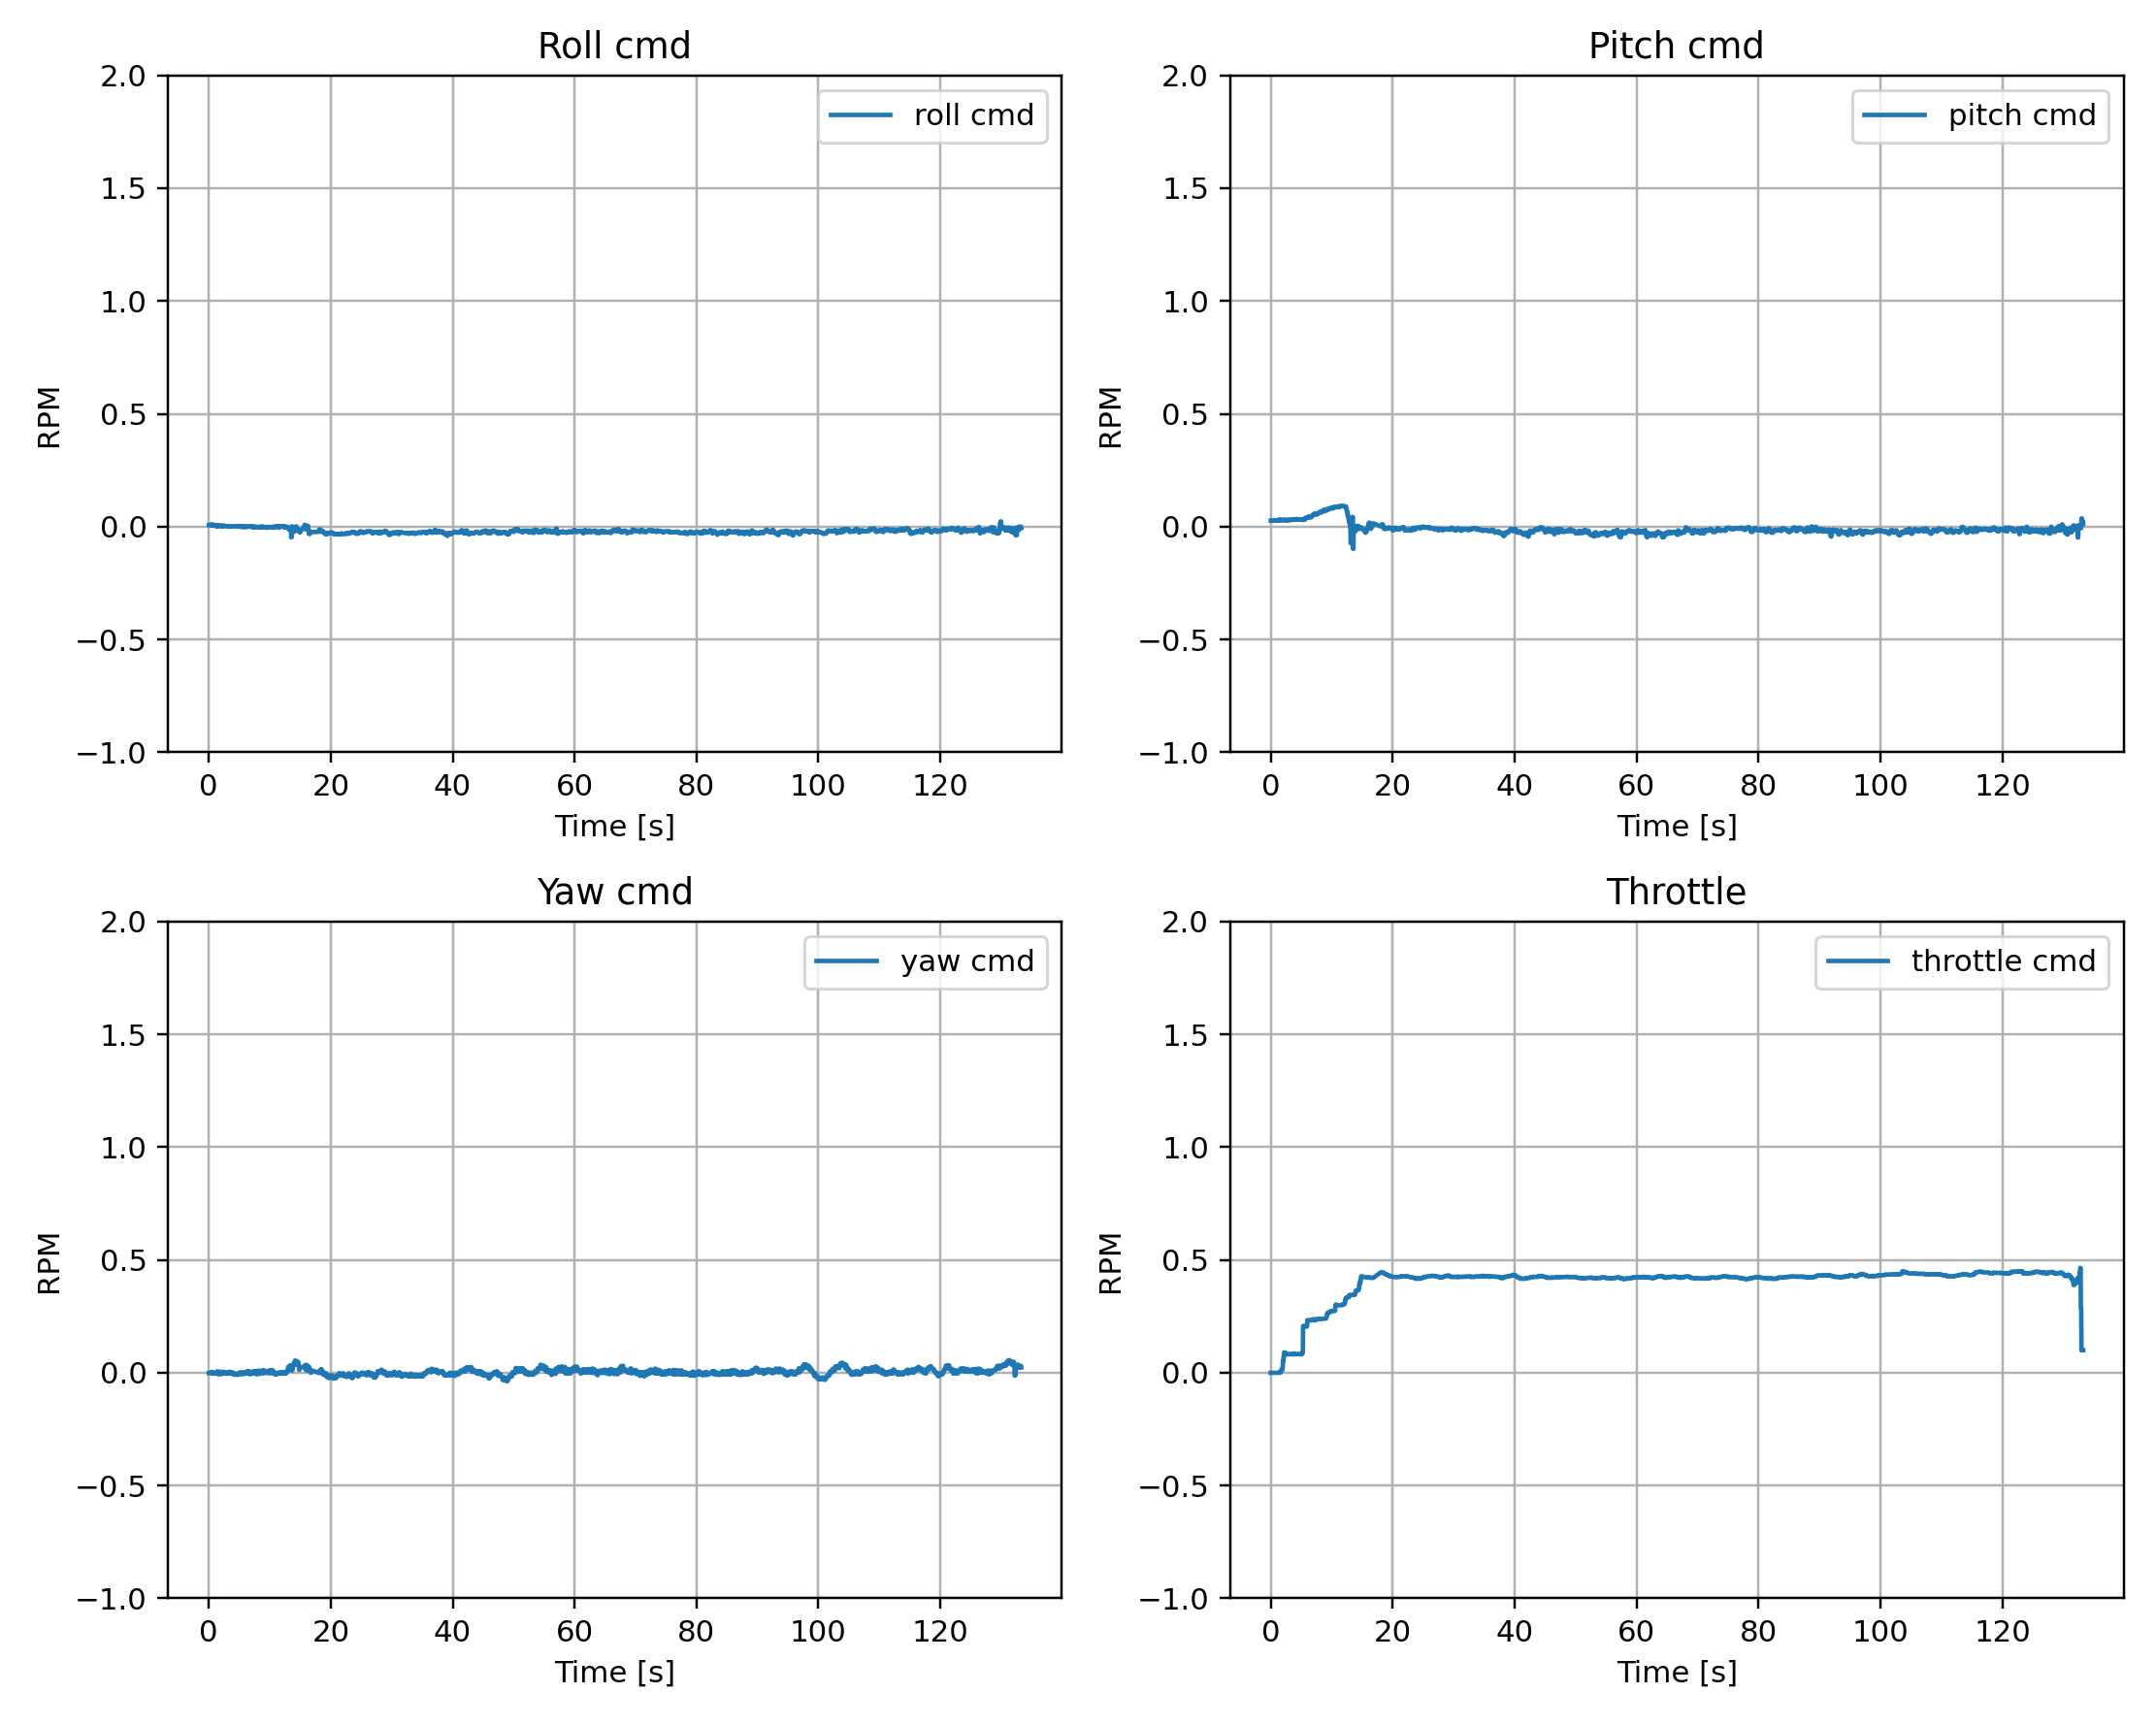

In [10]:
# Cmds

fig1, ax1 = plt.subplots(2, 2, figsize=(10,8))

# Rotor pairs

ax1[0][0].plot(time,control[0], label='roll cmd')
#ax1[0][0].plot(time,control[4], label='rotor5')

ax1[0][1].plot(time,control[1], label='pitch cmd')
#ax1[0][1].plot(time,control[5], label='rotor6')


ax1[1][0].plot(time,control[2], label='yaw cmd')
#ax1[1][0].plot(time,control[7], label='rotor8')

ax1[1][1].plot(time,control[3], label='throttle cmd')
#ax1[1][1].plot(time,control[6], label='rotor7')


for i in range(2):
    for j in range(2):
        ax1[i][j].set_xlabel('Time [s]')
        ax1[i][j].set_ylabel('RPM')
        ax1[i][j].set_ylim(-1,2)
        ax1[i][j].grid()
        ax1[i][j].legend()

ax1[0][0].set_title(f'Roll cmd')
ax1[0][1].set_title(f'Pitch cmd')
ax1[1][0].set_title(f'Yaw cmd')
ax1[1][1].set_title(f'Throttle')
fig1.tight_layout()

In [11]:
# Calculate motor cmds

ctrl_input = np.array([control[0].values, control[1].values, control[2].values, control[3].values,
                      np.zeros(control[0].size), np.zeros(control[0].size),
                      np.zeros(control[0].size), np.zeros(control[0].size)])

B_plus = np.array([[-1.4142,  1.4142,  2.0000, 2.0000, 0.4981, 0.0019, -0.0019, 0.0019],
              [ 1.4142,  1.4142, -2.0000, 2.0000, 0.0019, 0.4981,  0.0019,-0.0019],
              [ 1.4142, -1.4142,  2.0000, 2.0000,-0.0019, 0.0019,  0.4981, 0.0019],
              [-1.4142, -1.4142, -2.0000, 2.0000, 0.0019,-0.0019,  0.0019, 0.4981],
              [ 1.4142,  1.4142,  2.0000, 2.0000,-0.0019,-0.4981, -0.0019, 0.0019],
              [-1.4142,  1.4142, -2.0000, 2.0000,-0.4981,-0.0019,  0.0019,-0.0019],
              [-1.4142, -1.4142,  2.0000, 2.0000,-0.0019, 0.0019, -0.0019,-0.4981],
              [ 1.4142, -1.4142, -2.0000, 2.0000, 0.0019,-0.0019, -0.4981,-0.0019]])

delta_cmd = (B_plus @ ctrl_input) -1
#delta_cmd = (B_plus @ ctrl_input)

<IPython.core.display.Javascript object>


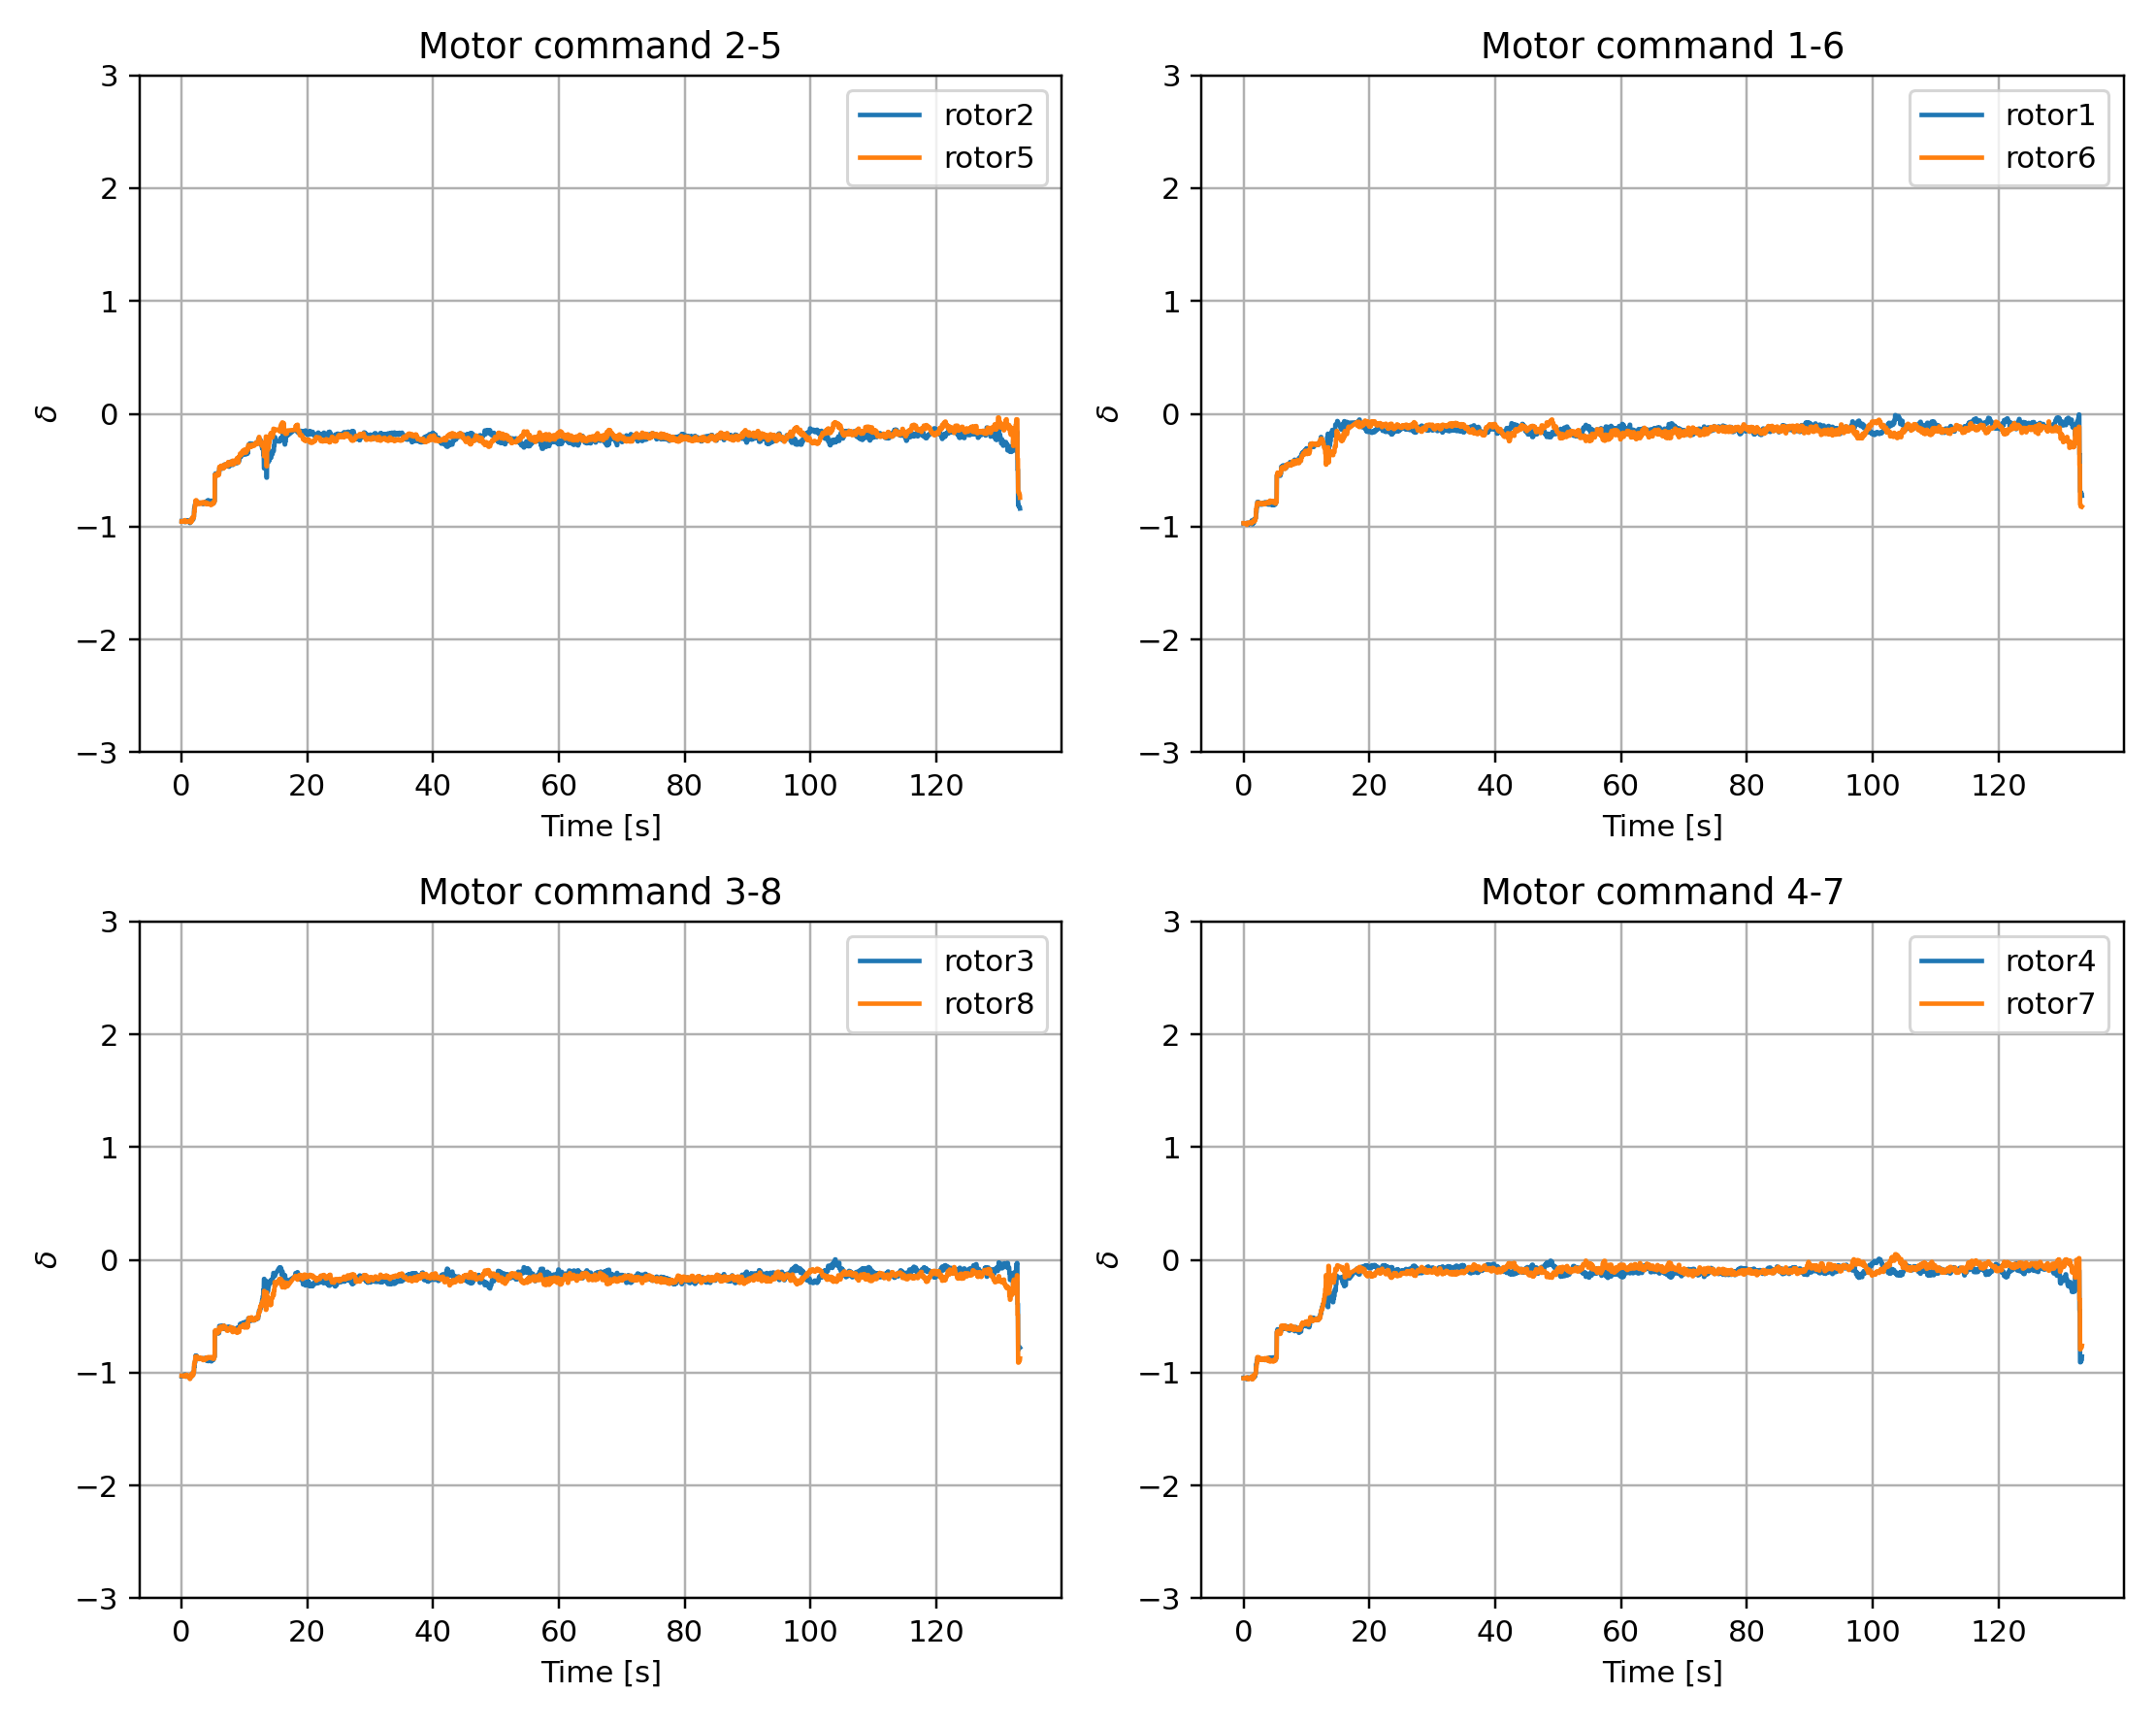

In [12]:
# motor cmds

fig1, ax1 = plt.subplots(2, 2, figsize=(10,8))

# Rotor pairs

ax1[0][0].plot(time,delta_cmd[1,:], label='rotor2')
ax1[0][0].plot(time,delta_cmd[4,:], label='rotor5')

ax1[0][1].plot(time,delta_cmd[0,:], label='rotor1')
ax1[0][1].plot(time,delta_cmd[5,:], label='rotor6')


ax1[1][0].plot(time,delta_cmd[2,:], label='rotor3')
ax1[1][0].plot(time,delta_cmd[7,:], label='rotor8')

ax1[1][1].plot(time,delta_cmd[3,:], label='rotor4')
ax1[1][1].plot(time,delta_cmd[6,:], label='rotor7')


for i in range(2):
    for j in range(2):
        ax1[i][j].set_xlabel('Time [s]')
        ax1[i][j].set_ylabel('$\delta$')
        ax1[i][j].set_ylim(-3,3)
        ax1[i][j].grid()
        ax1[i][j].legend()

ax1[0][0].set_title(f'Motor command 2-5')
ax1[0][1].set_title(f'Motor command 1-6')
ax1[1][0].set_title(f'Motor command 3-8')
ax1[1][1].set_title(f'Motor command 4-7')
fig1.tight_layout()

<IPython.core.display.Javascript object>


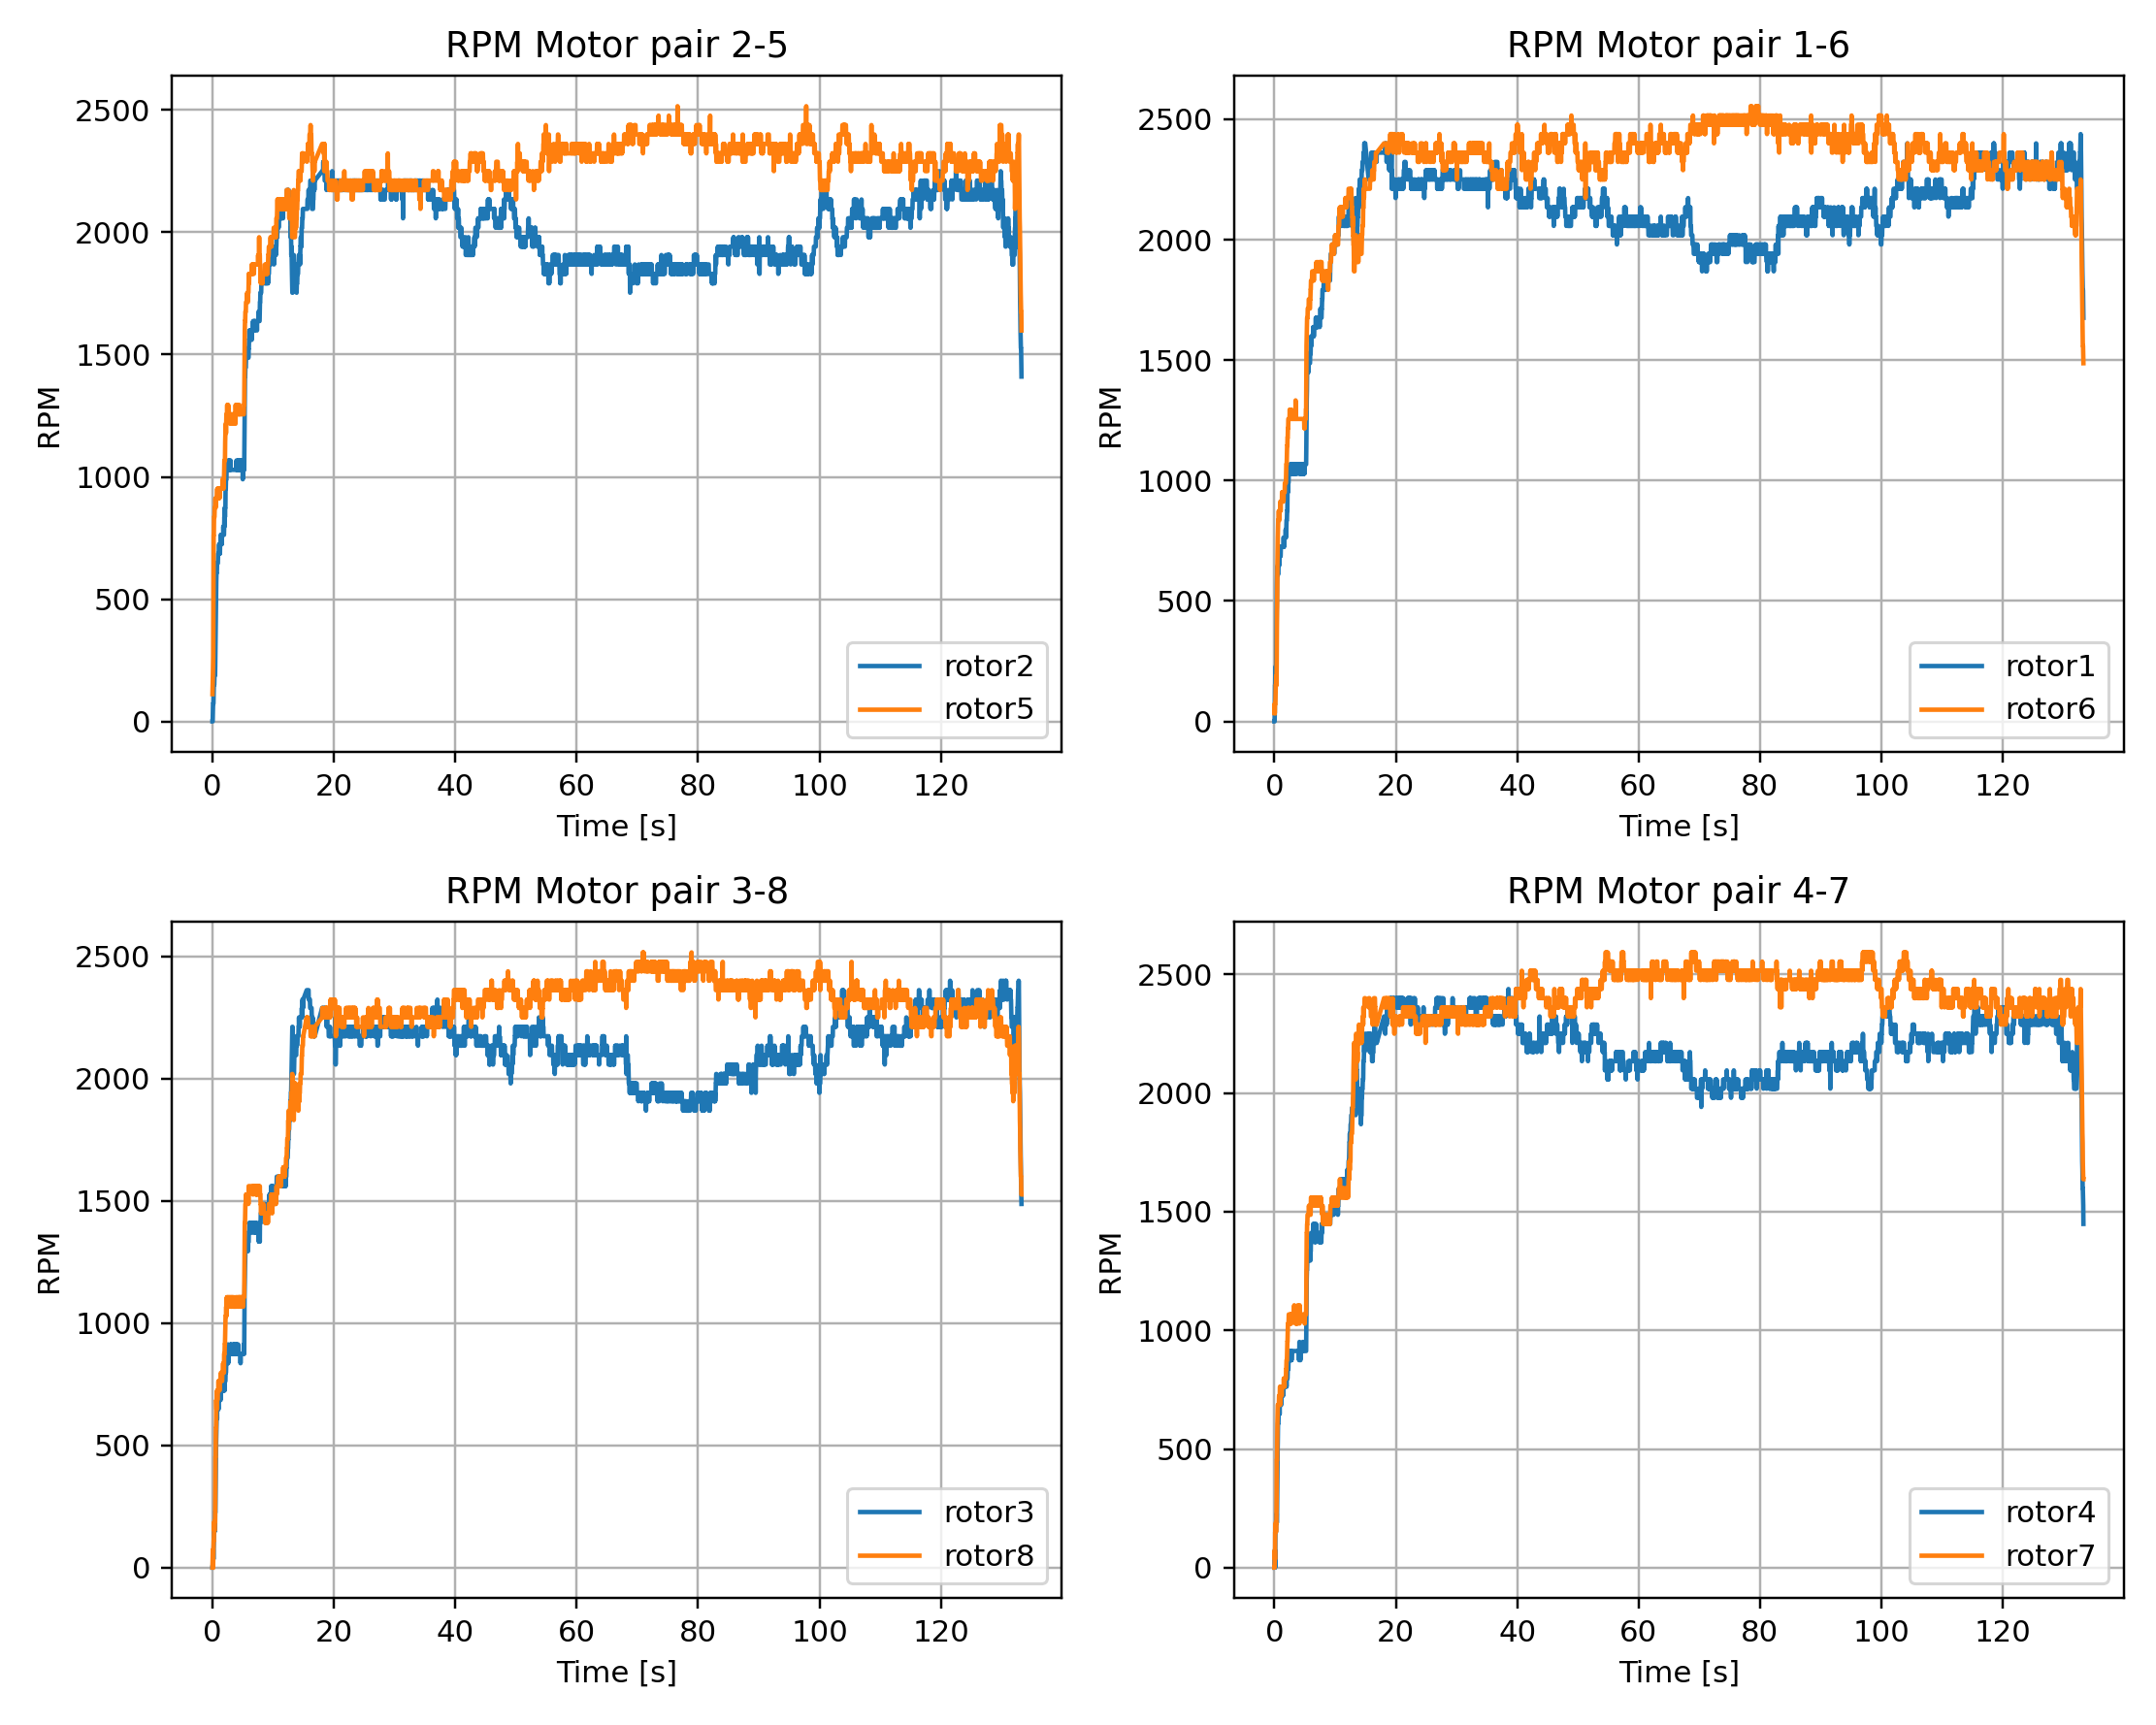

In [13]:
# rpm over time

fig1, ax1 = plt.subplots(2, 2, figsize=(10,8))

# Rotor pairs

ax1[0][0].plot(time,omega[1], label='rotor2')
ax1[0][0].plot(time,omega[4], label='rotor5')

ax1[0][1].plot(time,omega[0], label='rotor1')
ax1[0][1].plot(time,omega[5], label='rotor6')


ax1[1][0].plot(time,omega[2], label='rotor3')
ax1[1][0].plot(time,omega[7], label='rotor8')

ax1[1][1].plot(time,omega[3], label='rotor4')
ax1[1][1].plot(time,omega[6], label='rotor7')


for i in range(2):
    for j in range(2):
        ax1[i][j].set_xlabel('Time [s]')
        ax1[i][j].set_ylabel('RPM')
        #ax1[i][j].set_ylim(1500,2800)
        ax1[i][j].grid()
        ax1[i][j].legend()

ax1[0][0].set_title(f'RPM Motor pair 2-5')
ax1[0][1].set_title(f'RPM Motor pair 1-6')
ax1[1][0].set_title(f'RPM Motor pair 3-8')
ax1[1][1].set_title(f'RPM Motor pair 4-7')
fig1.tight_layout()

<IPython.core.display.Javascript object>


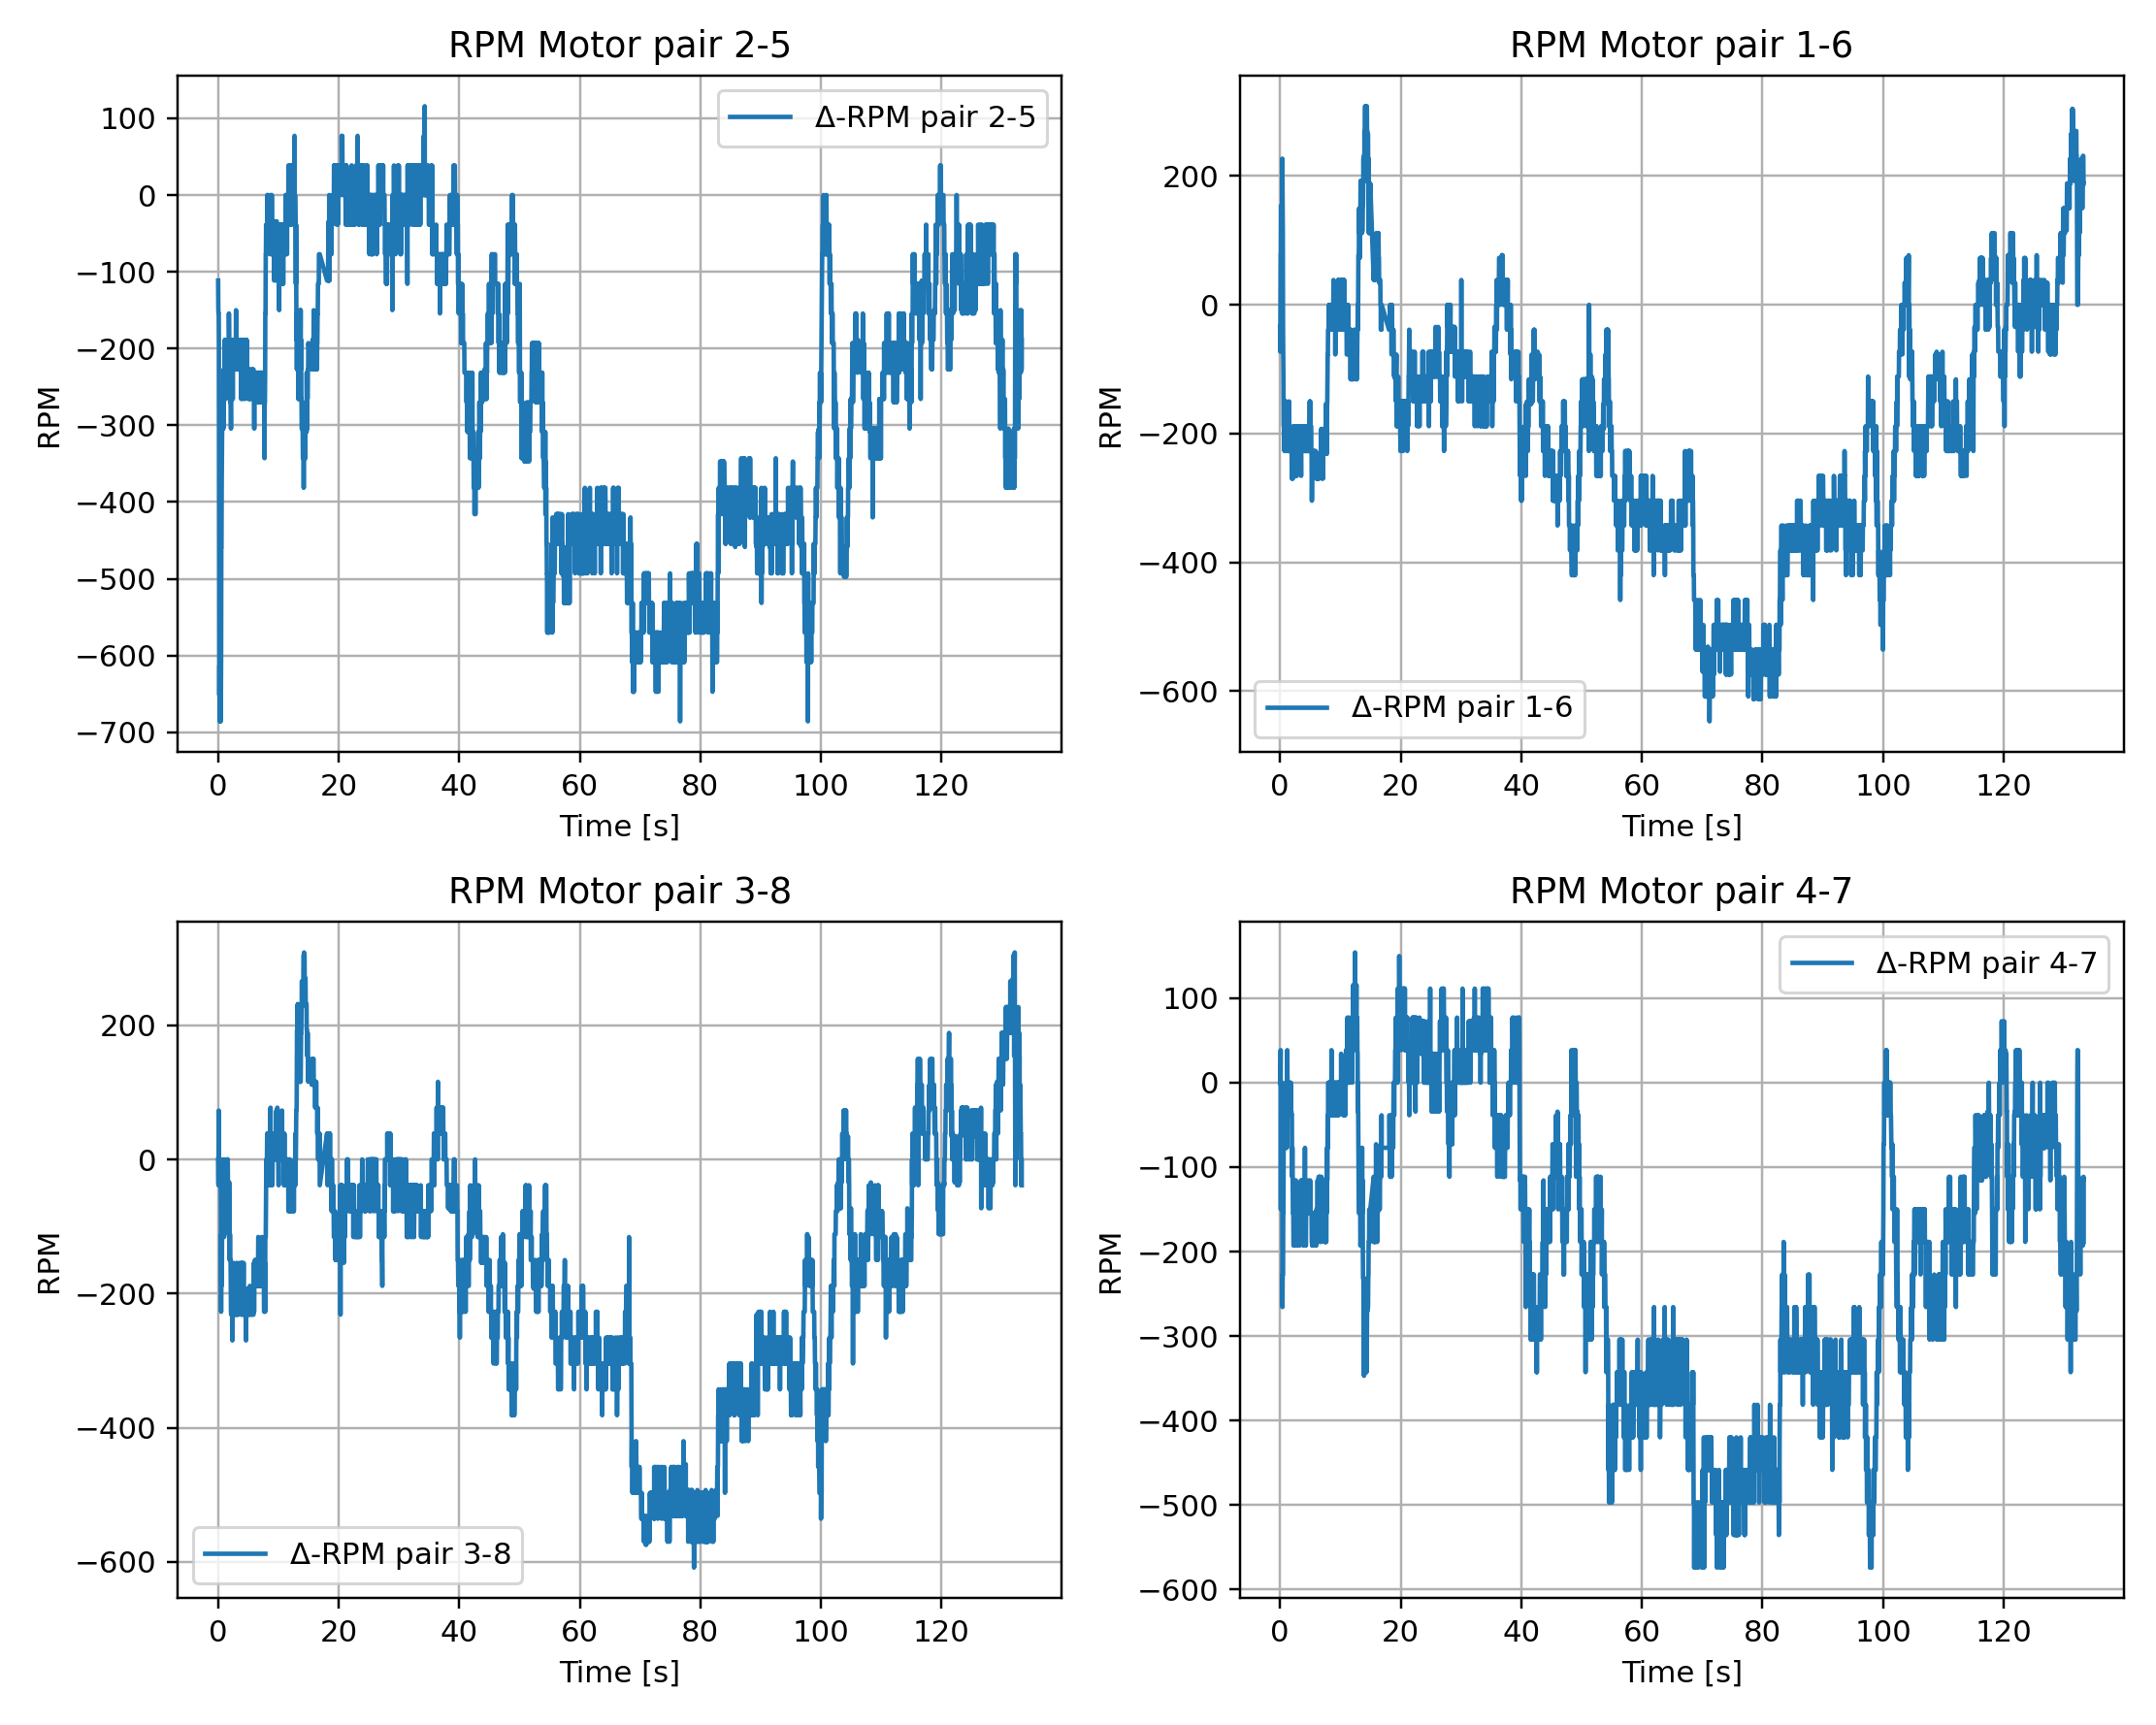

In [14]:
# delta RPM

fig1, ax1 = plt.subplots(2, 2, figsize=(10,8))

# Rotor pairs

ax1[0][0].plot(time,omega[1] - omega[4], label='$\Delta$-RPM pair 2-5')
#ax1[0][0].plot(time,omega[4], label='rotor5')

ax1[0][1].plot(time,omega[0] - omega[5], label='$\Delta$-RPM pair 1-6')
#ax1[0][1].plot(time,omega[5], label='rotor6')


ax1[1][0].plot(time,omega[2] - omega[7], label='$\Delta$-RPM pair 3-8')
#ax1[1][0].plot(time,omega[7], label='rotor8')

ax1[1][1].plot(time,omega[3] - omega[6], label='$\Delta$-RPM pair 4-7')
#ax1[1][1].plot(time,omega[6], label='rotor7')


for i in range(2):
    for j in range(2):
        ax1[i][j].set_xlabel('Time [s]')
        ax1[i][j].set_ylabel('RPM')
        #ax1[i][j].set_ylim(1900,2500)
        ax1[i][j].grid()
        ax1[i][j].legend()

ax1[0][0].set_title(f'RPM Motor pair 2-5')
ax1[0][1].set_title(f'RPM Motor pair 1-6')
ax1[1][0].set_title(f'RPM Motor pair 3-8')
ax1[1][1].set_title(f'RPM Motor pair 4-7')
fig1.tight_layout()

<IPython.core.display.Javascript object>


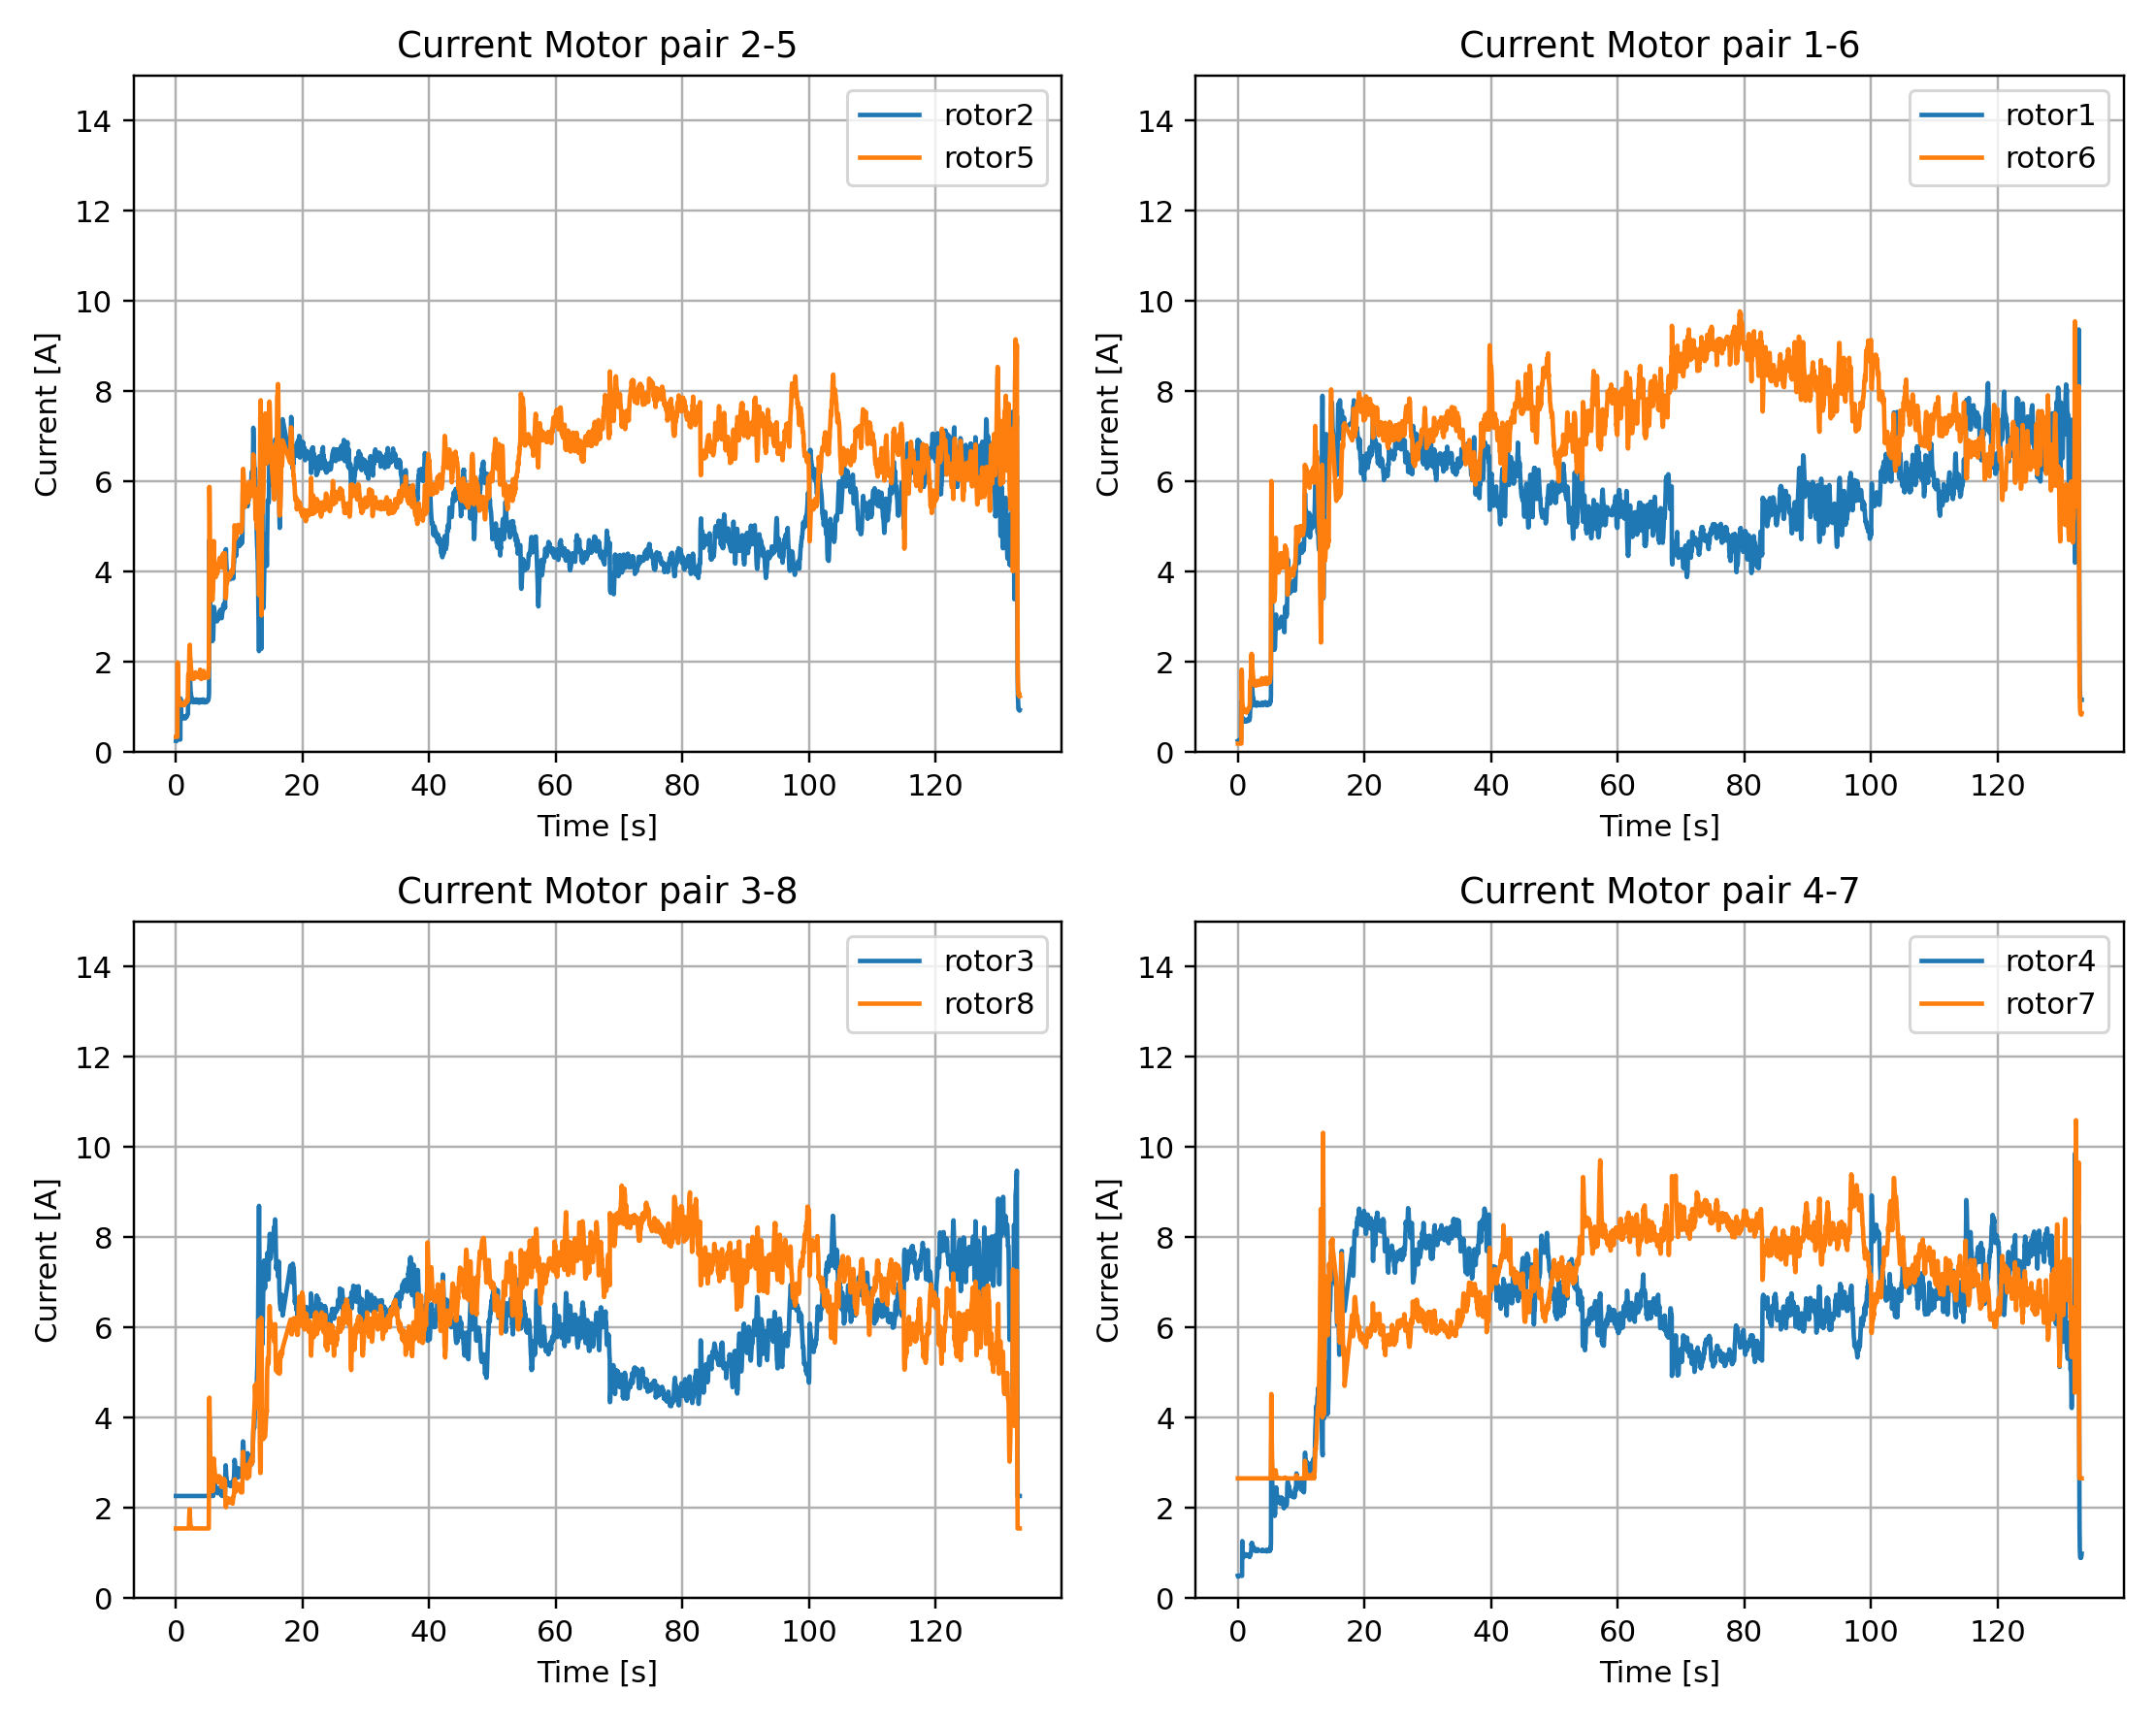

In [15]:
# current over time

fig2, ax2 = plt.subplots(2, 2, figsize=(10,8))

# Rotor pairs

ax2[0][0].plot(time,current[1], label='rotor2')
ax2[0][0].plot(time,current[4], label='rotor5')

ax2[0][1].plot(time,current[0], label='rotor1')
ax2[0][1].plot(time,current[5], label='rotor6')


ax2[1][0].plot(time,current[2], label='rotor3')
ax2[1][0].plot(time,current[7], label='rotor8')

ax2[1][1].plot(time,current[3], label='rotor4')
ax2[1][1].plot(time,current[6], label='rotor7')


for i in range(2):
    for j in range(2):
        ax2[i][j].set_xlabel('Time [s]')
        ax2[i][j].set_ylabel('Current [A]')
        ax2[i][j].set_ylim(0,15)
        ax2[i][j].grid()
        ax2[i][j].legend()

ax2[0][0].set_title(f'Current Motor pair 2-5')
ax2[0][1].set_title(f'Current Motor pair 1-6')
ax2[1][0].set_title(f'Current Motor pair 3-8')
ax2[1][1].set_title(f'Current Motor pair 4-7')
fig2.tight_layout()

<IPython.core.display.Javascript object>


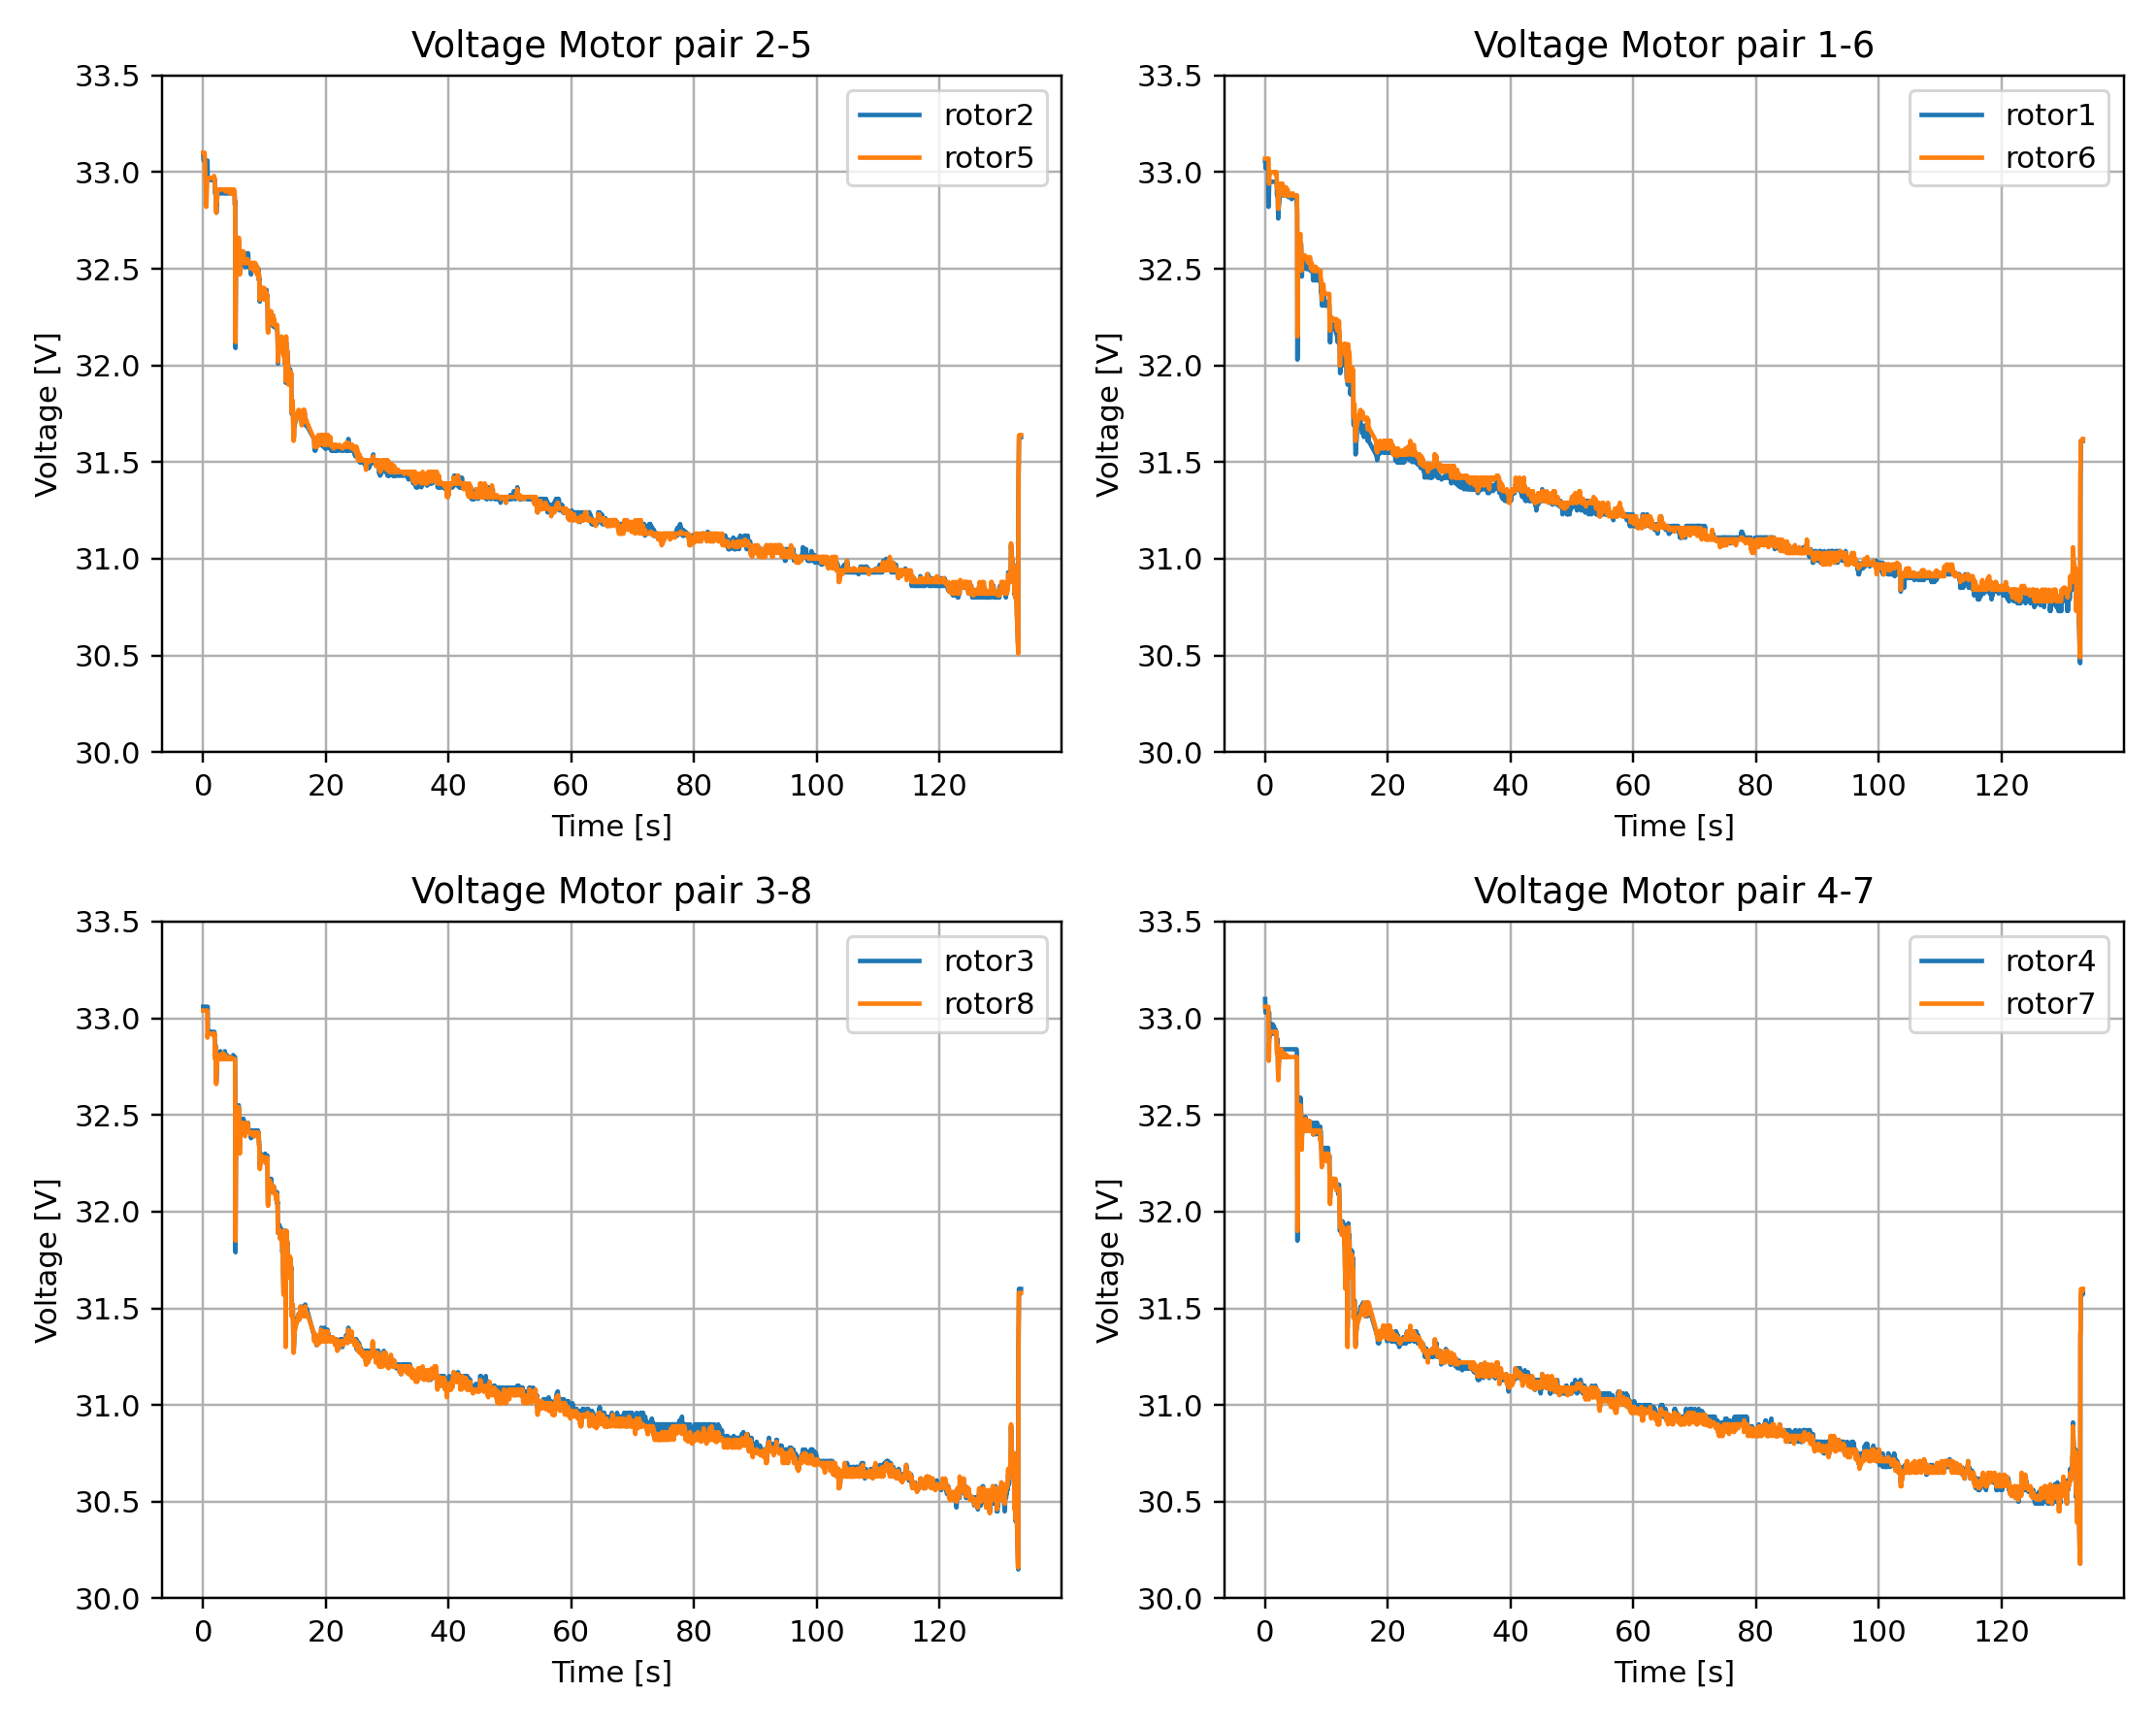

In [16]:
# current over time

fig1, ax1 = plt.subplots(2, 2, figsize=(10,8))

# Rotor pairs

ax1[0][0].plot(time,voltage[1], label='rotor2')
ax1[0][0].plot(time,voltage[4], label='rotor5')

ax1[0][1].plot(time,voltage[0], label='rotor1')
ax1[0][1].plot(time,voltage[5], label='rotor6')


ax1[1][0].plot(time,voltage[2], label='rotor3')
ax1[1][0].plot(time,voltage[7], label='rotor8')

ax1[1][1].plot(time,voltage[3], label='rotor4')
ax1[1][1].plot(time,voltage[6], label='rotor7')


for i in range(2):
    for j in range(2):
        ax1[i][j].set_xlabel('Time [s]')
        ax1[i][j].set_ylabel('Voltage [V]')
        ax1[i][j].set_ylim(30, 33.5)
        ax1[i][j].grid()
        ax1[i][j].legend()

ax1[0][0].set_title(f'Voltage Motor pair 2-5')
ax1[0][1].set_title(f'Voltage Motor pair 1-6')
ax1[1][0].set_title(f'Voltage Motor pair 3-8')
ax1[1][1].set_title(f'Voltage Motor pair 4-7')
fig1.tight_layout()

<IPython.core.display.Javascript object>


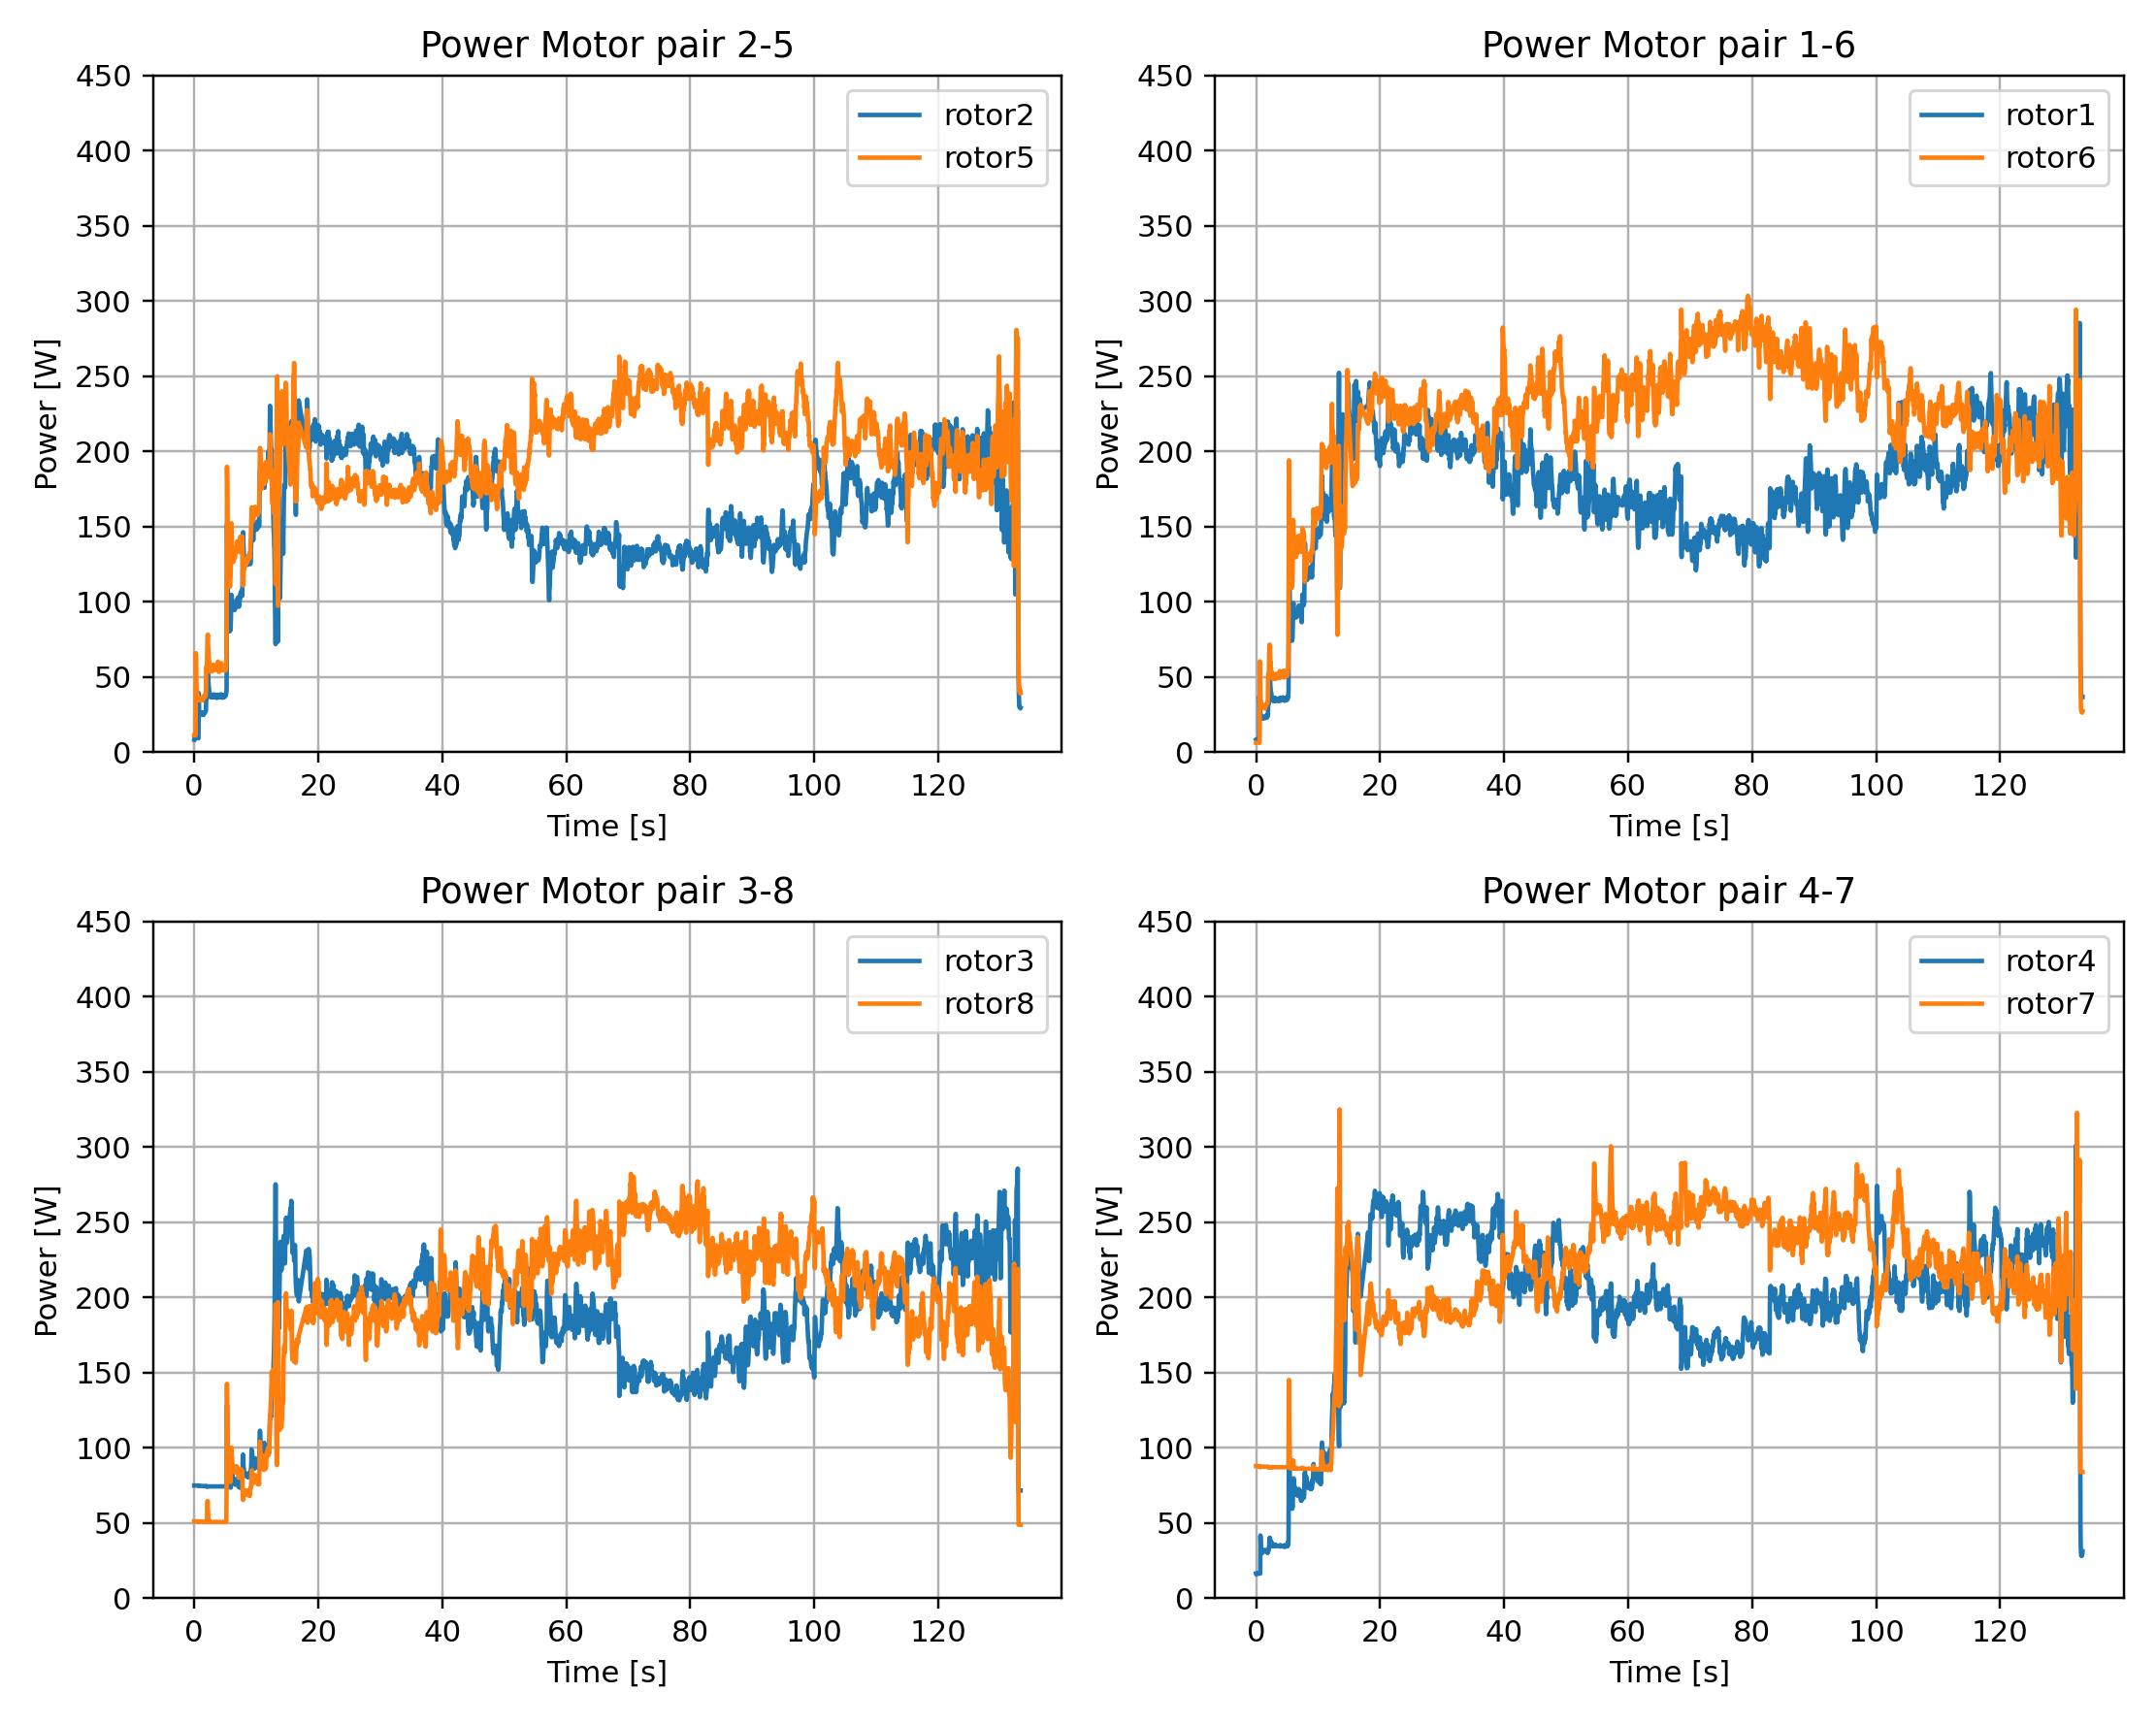

In [17]:
# power over time

fig1, ax1 = plt.subplots(2, 2, figsize=(10,8))

# Rotor pairs

ax1[0][0].plot(time,power[1], label='rotor2')
ax1[0][0].plot(time,power[4], label='rotor5')

ax1[0][1].plot(time,power[0], label='rotor1')
ax1[0][1].plot(time,power[5], label='rotor6')


ax1[1][0].plot(time,power[2], label='rotor3')
ax1[1][0].plot(time,power[7], label='rotor8')

ax1[1][1].plot(time,power[3], label='rotor4')
ax1[1][1].plot(time,power[6], label='rotor7')


for i in range(2):
    for j in range(2):
        ax1[i][j].set_xlabel('Time [s]')
        ax1[i][j].set_ylabel('Power [W]')
        ax1[i][j].set_ylim(0,450)
        ax1[i][j].grid()
        ax1[i][j].legend()

ax1[0][0].set_title(f'Power Motor pair 2-5')
ax1[0][1].set_title(f'Power Motor pair 1-6')
ax1[1][0].set_title(f'Power Motor pair 3-8')
ax1[1][1].set_title(f'Power Motor pair 4-7')
fig1.tight_layout()

<IPython.core.display.Javascript object>


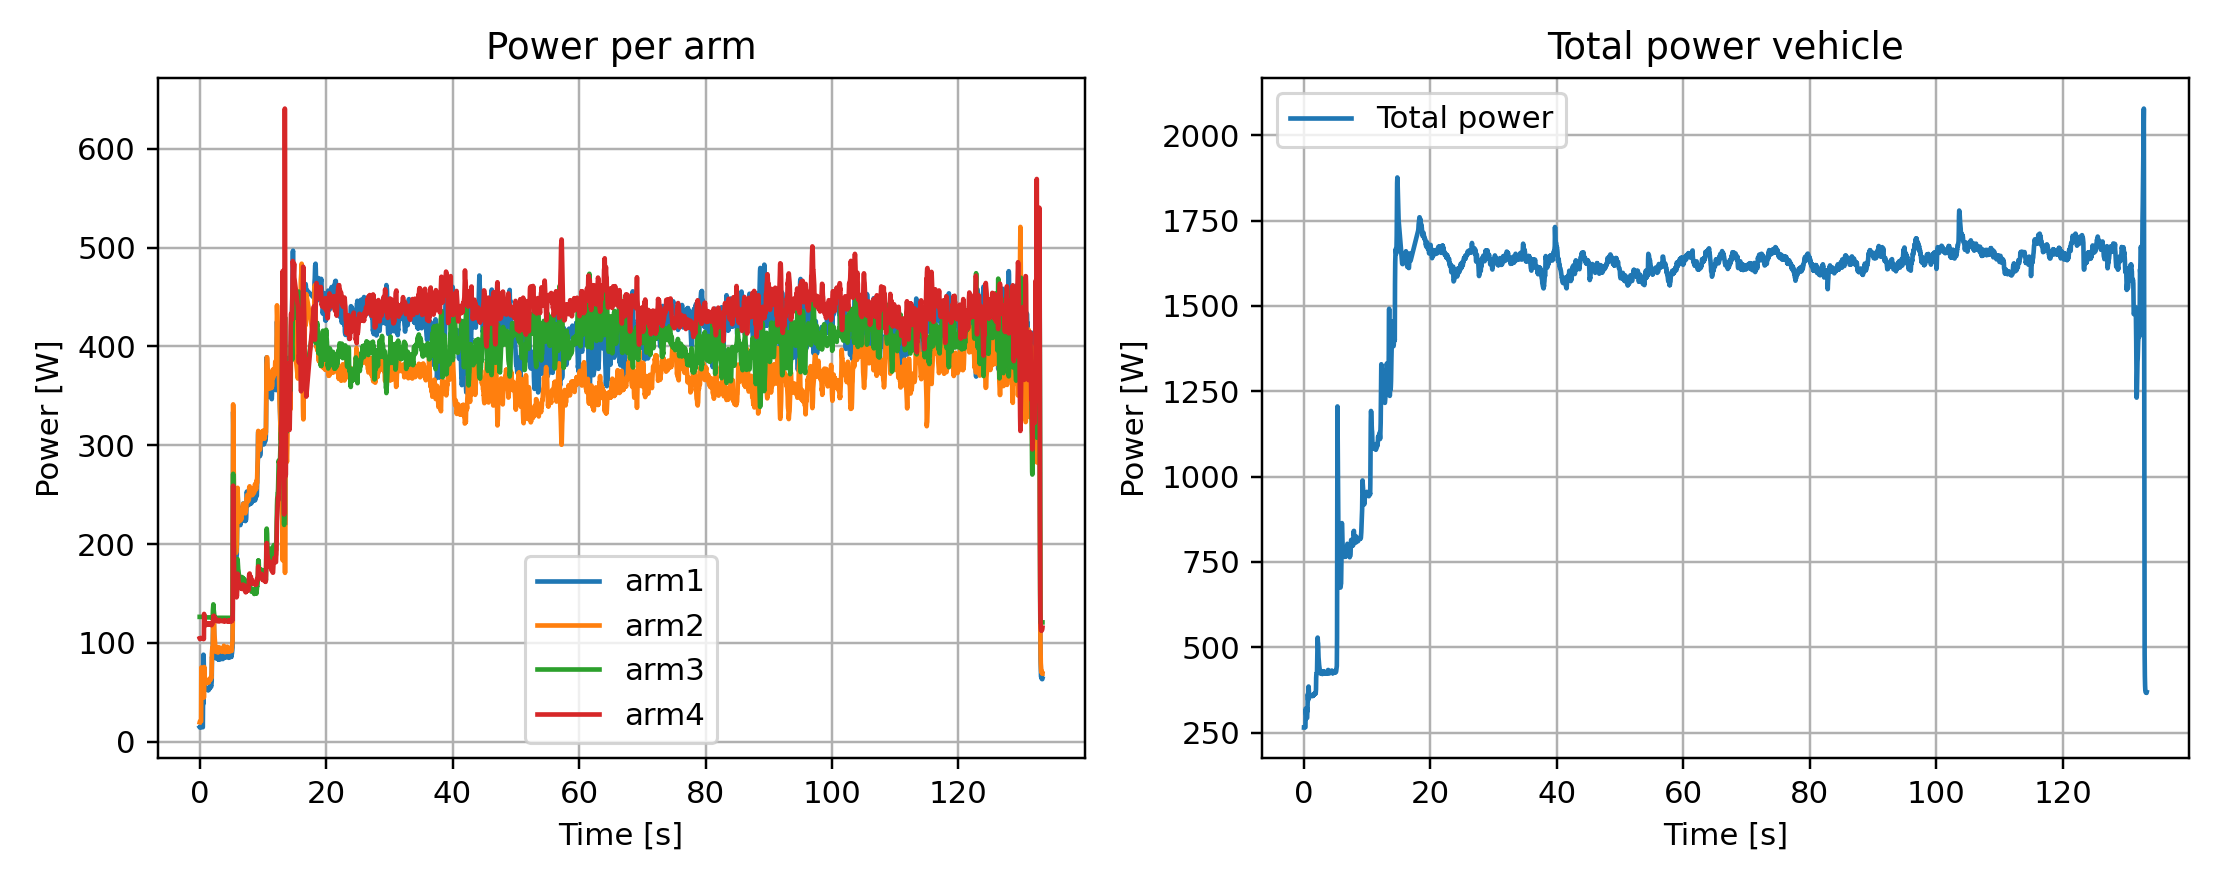

In [18]:
# Total power over time

fig1, ax1 = plt.subplots(1,2, figsize=(10,4))

# Rotor pairs

ax1[0].plot(time,power_pair['16'], label='arm1')
ax1[0].plot(time,power_pair['25'], label='arm2')
ax1[0].plot(time,power_pair['38'], label='arm3')
ax1[0].plot(time,power_pair['47'], label='arm4')

ax1[1].plot(time,total_power, label='Total power')

for i in range(2):
        ax1[i].set_xlabel('Time [s]')
        ax1[i].set_ylabel('Power [W]')
        #ax1[i].set_ylim(0,450)
        ax1[i].grid()
        ax1[i].legend()

ax1[0].set_title(f'Power per arm')
#ax1[0][1].set_title(f'Power Motor pair 1-6')
ax1[1].set_title(f'Total power vehicle')
#ax1[1][1].set_title(f'Power Motor pair 4-7')
fig1.tight_layout()

<IPython.core.display.Javascript object>


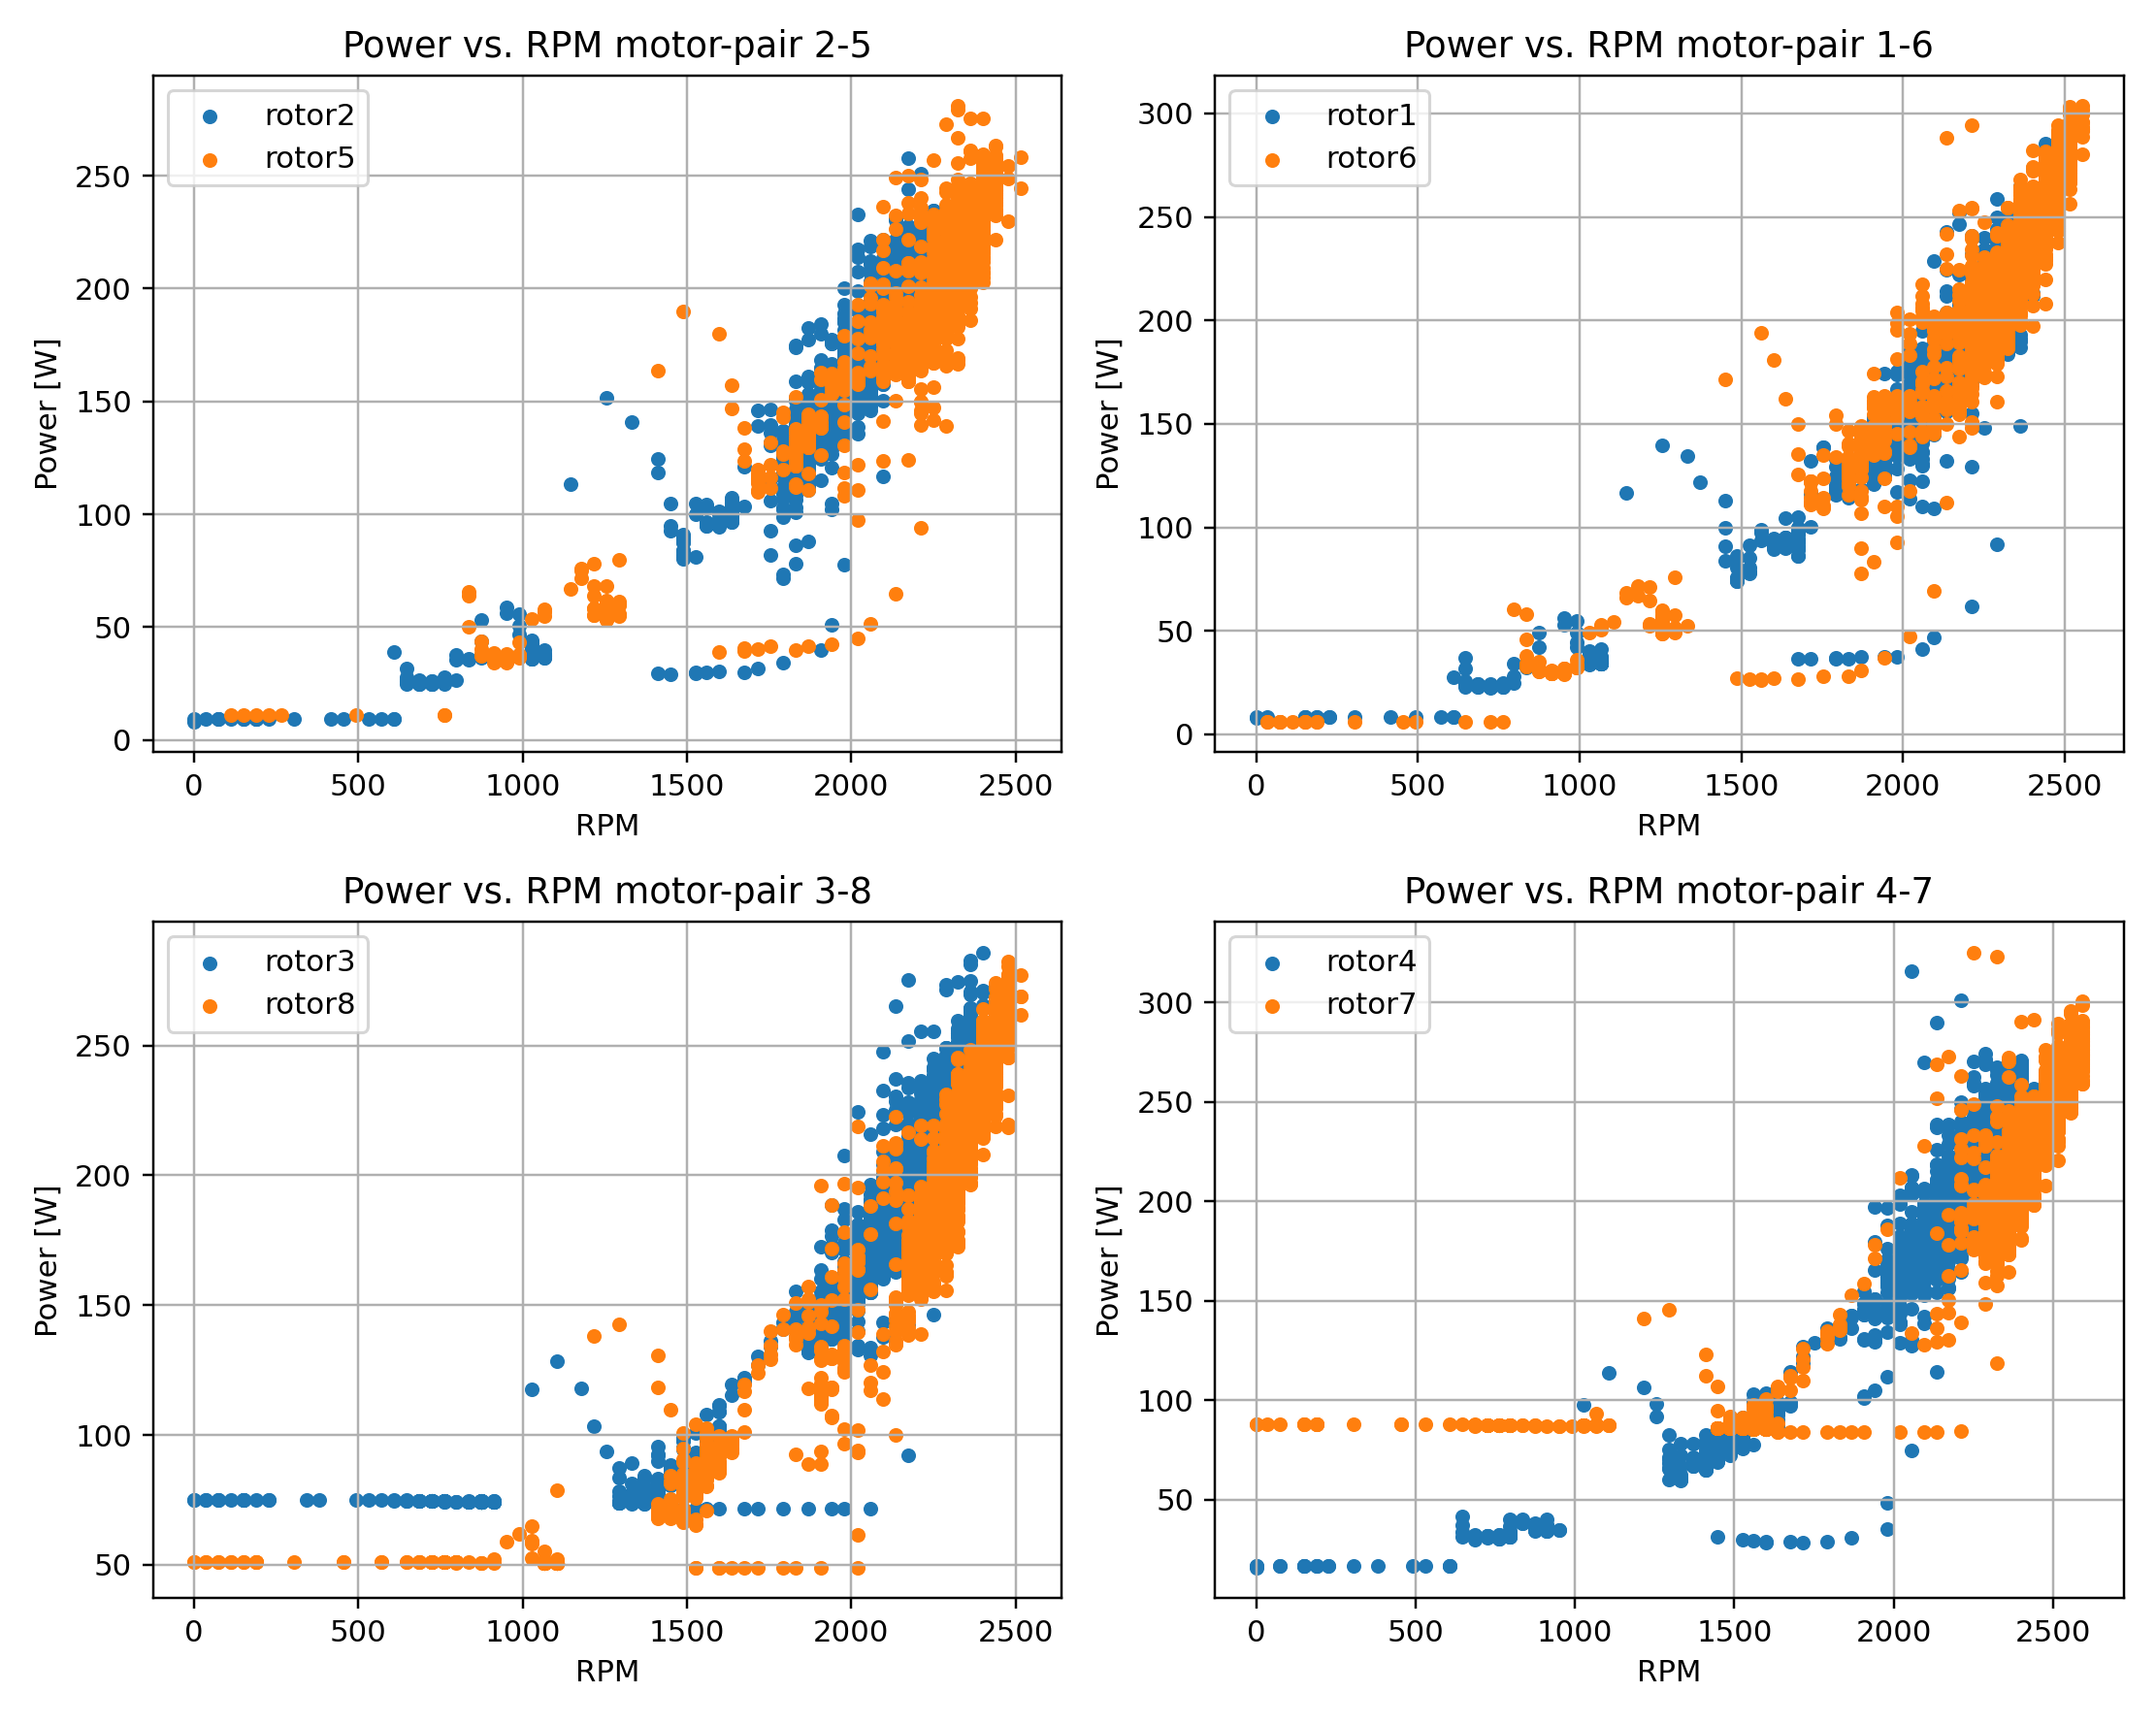

In [19]:
# Power over effective RPM

fig1, ax1 = plt.subplots(2, 2, figsize=(10,8))

# Rotor pairs

ax1[0][0].scatter(omega[1], power[1], s=markersize, label='rotor2')
ax1[0][0].scatter(omega[4], power[4], s=markersize, label='rotor5')

ax1[0][1].scatter(omega[0], power[0], s=markersize, label='rotor1')
ax1[0][1].scatter(omega[5], power[5], s=markersize, label='rotor6')

ax1[1][0].scatter(omega[2], power[2], s=markersize, label='rotor3')
ax1[1][0].scatter(omega[7], power[7], s=markersize, label='rotor8')

ax1[1][1].scatter(omega[3], power[3], s=markersize, label='rotor4')
ax1[1][1].scatter(omega[6], power[6], s=markersize, label='rotor7')


for i in range(2):
    for j in range(2):
        ax1[i][j].set_xlabel('RPM')
        ax1[i][j].set_ylabel('Power [W]')
        #ax1[i][j].set_xlim(0,2500)
        #ax1[i][j].set_ylim(0,450)
        ax1[i][j].grid()
        ax1[i][j].legend()

ax1[0][0].set_title(f'Power vs. RPM motor-pair 2-5')
ax1[0][1].set_title(f'Power vs. RPM motor-pair 1-6')
ax1[1][0].set_title(f'Power vs. RPM motor-pair 3-8')
ax1[1][1].set_title(f'Power vs. RPM motor-pair 4-7')
fig1.tight_layout()

<IPython.core.display.Javascript object>


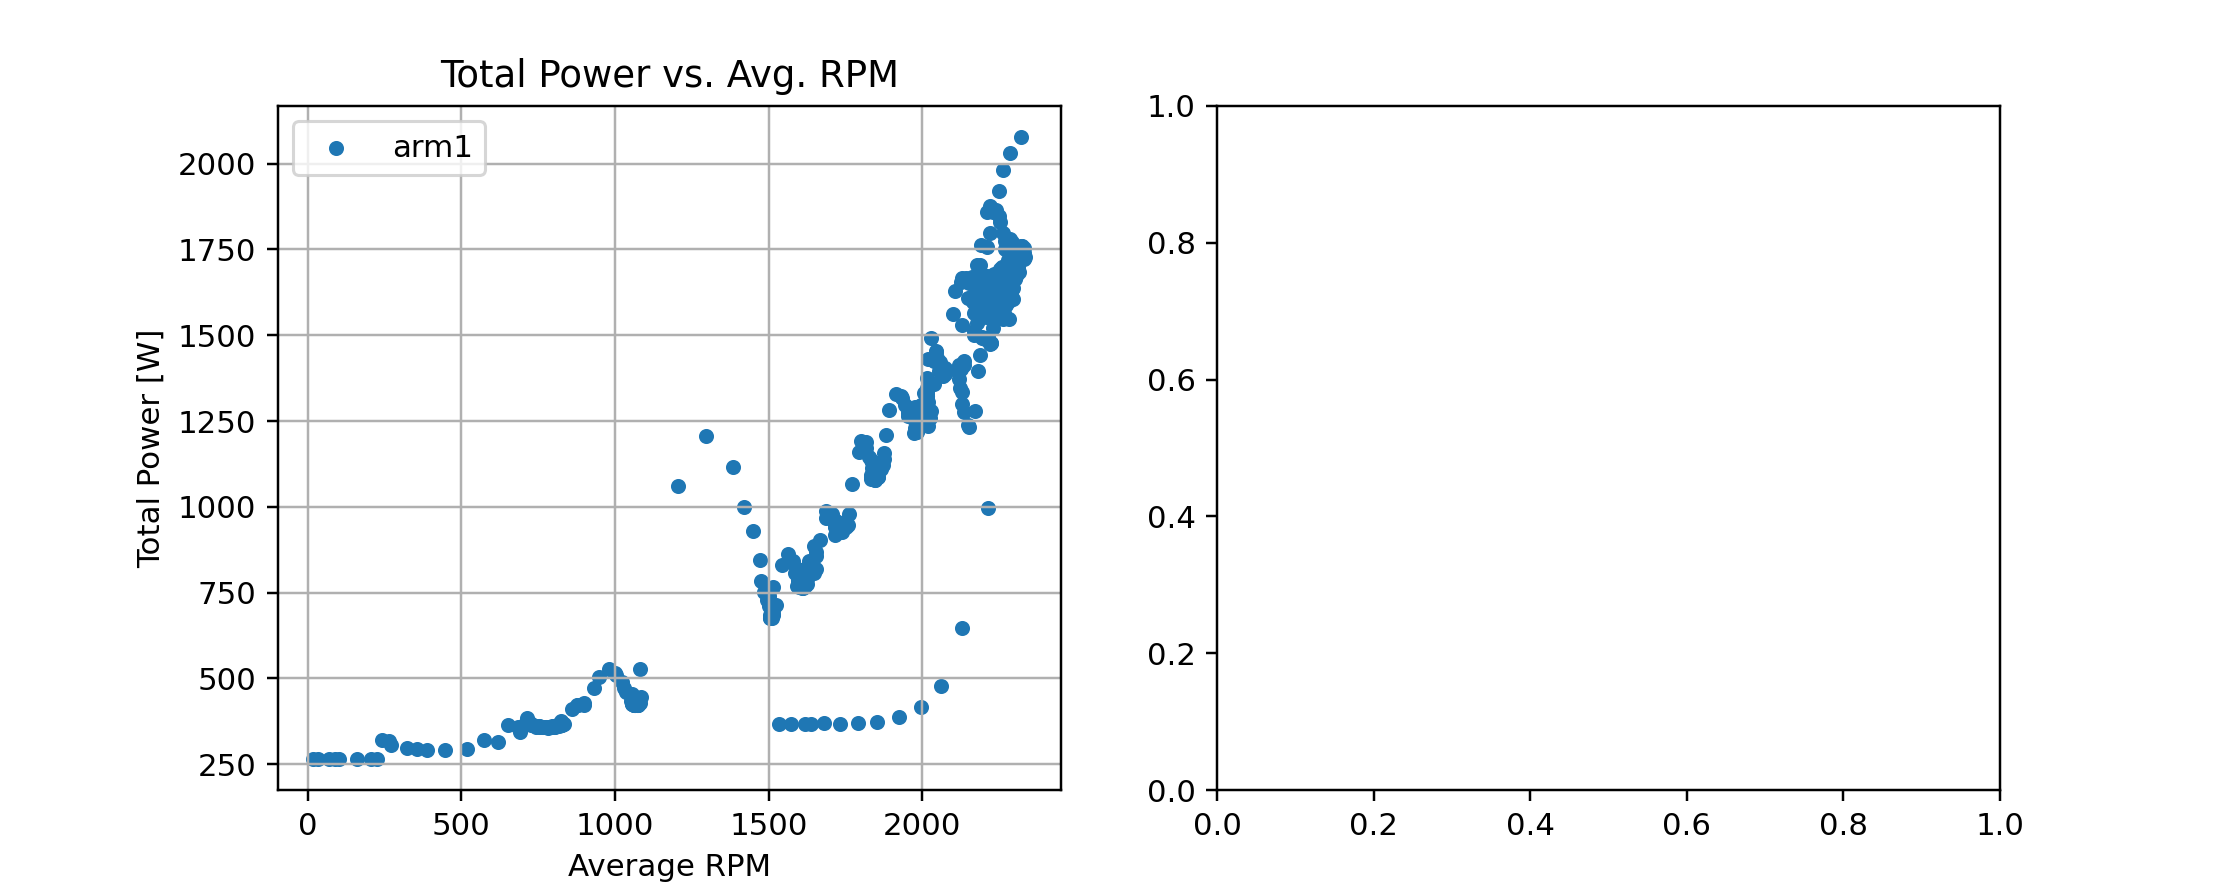

NameError: name 'delta0' is not defined

In [20]:
# Total power over average RPM

fig1, ax1 = plt.subplots(1,2,figsize=(10,4))

# Rotor pairs

ax1[0].scatter(avg_omega, total_power, s=markersize, label='arm1')

ax1[0].set_xlabel('Average RPM')
ax1[0].set_ylabel('Total Power [W]')
ax1[0].grid()
ax1[0].legend()
ax1[0].set_title(f'Total Power vs. Avg. RPM')

ax1[1].scatter(time, delta0, s=markersize, label='arm1')

ax1[1].set_xlabel('time')
ax1[1].set_ylabel('Total Power [W]')
ax1[1].grid()
ax1[1].legend()
ax1[1].set_title(f'nsh command')

fig1.tight_layout()